# Critical Infrastructure

Notebook environment to migrate netcdf files to CF compliant zarr#

In [5]:
# Optional; code formatter, installed as jupyter lab extension
#%load_ext lab_black
# Optional; code formatter, installed as jupyter notebook extension
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

### Configure OS independent paths

In [6]:
# Import standard packages
import os
import pathlib
import sys
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from shapely import wkb

# Make root directories importable by appending root to path
cwd = pathlib.Path().resolve()
sys.path.append(os.path.dirname(cwd))

# Get root paths
home = pathlib.Path().home()
root = home.root

# Import custom functionality
from coclicodata.drive_config import p_drive
from coclicodata.etl.cf_compliancy_checker import check_compliancy, save_compliancy
from coclicodata.etl.cloud_utils import (
    load_google_credentials,
    dir_to_google_cloud,
    file_to_google_cloud,
)

# Define (local and) remote drives
coclico_data_dir_fast = p_drive.joinpath("11207608-coclico", "FASTTRACK_DATA")
coclico_data_dir_full = p_drive.joinpath("11207608-coclico", "FULLTRACK_DATA")

# Workaround to the Windows OS (10) udunits error after installation of cfchecker: https://github.com/SciTools/iris/issues/404
# os.environ["UDUNITS2_XML_PATH"] = str(
#     home.joinpath(  # change to the udunits2.xml file dir in your Python installation
#         r"Anaconda3\pkgs\udunits2-2.2.28-h892ecd3_0\Library\share\udunits\udunits2.xml"
#     )
# )



<IPython.core.display.Javascript object>

In [7]:
# Project paths & files (manual input)

# coastal LAU and NUTS coastal 
LAU_dataset_dir = coclico_data_dir_fast.joinpath("XX_LAU")
NUTS2_dataset_dir = coclico_data_dir_fast.joinpath("XX_NUTS")
LAU_ds_path = LAU_dataset_dir.joinpath("LAU_2020_NUTS_2021_01M_3035_CM.parquet")
NUTS2_ds_path = NUTS2_dataset_dir.joinpath("NUTS2_RG_01M_2021_3035_CM.parquet")

# CEED data
CEED_dataset_dir = coclico_data_dir_full.joinpath("WP5/data/nuts2_ceed")

<IPython.core.display.Javascript object>

### Getting the dataframe info

<Axes: >

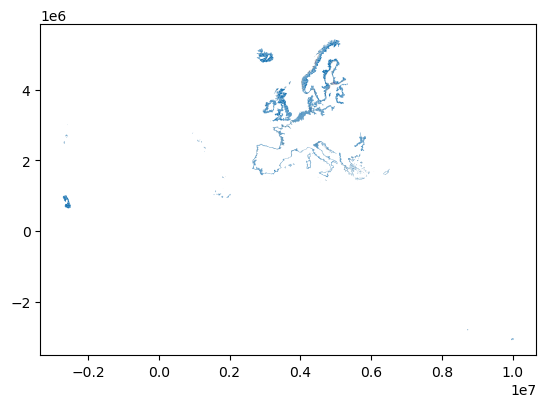

<IPython.core.display.Javascript object>

In [8]:
# load parquet data into geopandas geodataframes
LAU = pd.read_parquet(LAU_ds_path)
NUTS2 = pd.read_parquet(NUTS2_ds_path)

# fix geometries
LAU["geometry"] = LAU["geometry"].apply(lambda x: wkb.loads(x) if x else None)
NUTS2["geometry"] = NUTS2["geometry"].apply(lambda x: wkb.loads(x) if x else None)

# make geodataframe
LAU_gdf = gpd.GeoDataFrame(LAU, geometry="geometry")
NUTS2_gdf = gpd.GeoDataFrame(NUTS2, geometry="geometry")
LAU_gdf.plot()

### Single area comp

In [30]:
# load CEED parquet data into geopandas dataframes
# NL33 (South Holland - largest)
# NL41 (Brabant - second largest)
# NL32 (North Holland - third largest)
# NL22 (Gelderland - fourth largest)
CEED = pd.read_parquet(CEED_dataset_dir.joinpath("NL32_CEED.parquet"))

# fix geometries
CEED["geometry"] = CEED["geometry"].apply(lambda x: wkb.loads(x) if x else None)

# make geodataframe
CEED_gdf = gpd.GeoDataFrame(CEED, geometry="geometry")

<IPython.core.display.Javascript object>

<Axes: >

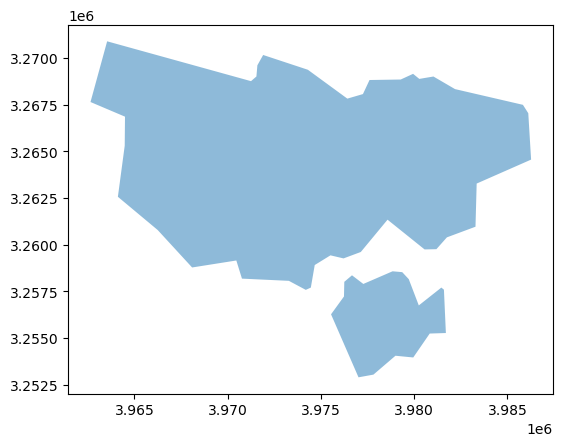

<IPython.core.display.Javascript object>

In [31]:
# cut up the NUTS2 CEED into smaller LAU CEED files
test_file = "NL_GM0363"

# select one LAU in the file
LAU_AMS = LAU_gdf[LAU_gdf["GISCO_ID"] == test_file]
LAU_AMS.plot(alpha=0.5)

In [32]:
# match geospatially the geodataframes (spatial join)
LAU_AMS_CEED = gpd.sjoin(CEED_gdf, LAU_AMS, how="inner", op="intersects")

c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


<IPython.core.display.Javascript object>

In [35]:
# set the CRS
LAU_AMS_CEED = LAU_AMS_CEED.set_crs(epsg=3035)

# rename the FID column to avoid confusion
LAU_AMS_CEED = LAU_AMS_CEED.rename(columns={"FID": "LAU_FID"})

# drop all attributes except geometry
LAU_AMS_CEED = LAU_AMS_CEED[["geometry"]]

# reset multi-index to add type
LAU_AMS_CEED_plain = LAU_AMS_CEED.reset_index()
#LAU_AMS_CEED["type"] = np.array(LAU_AMS_CEED_plain.level_0)

# multi-index names and counter info 
# CEEDtype = np.array(LAU_AMS_CEED.index.levels[0])
# for i in CEEDtype:
#     print(i, LAU_AMS_CEED.xs(i).shape)

<IPython.core.display.Javascript object>

In [36]:
# test
LAU_AMS_CEED_refact = LAU_AMS_CEED_plain.drop(columns=["level_1"], inplace=True) 
LAU_AMS_CEED_refact = LAU_AMS_CEED_plain.rename(columns={"level_0": "type"})
LAU_AMS_CEED_refact

type                                           geometry
0       buildings  POLYGON ((3980679.456 3255448.051, 3980679.457...
1       buildings  POLYGON ((3979429.675 3254097.242, 3979429.675...
2       buildings  POLYGON ((3979424.475 3254098.462, 3979424.475...
3       buildings  POLYGON ((3979419.210 3254099.694, 3979419.210...
4       buildings  POLYGON ((3979411.056 3254112.433, 3979411.056...
...           ...                                                ...
193871       road  LINESTRING (3965615.648 3268527.148, 3965600.1...
193872       road  LINESTRING (3964691.293 3268754.238, 3964753.0...
193873       road  LINESTRING (3965144.431 3268463.035, 3965136.5...
193874       road  LINESTRING (3964753.004 3268767.519, 3964767.8...
193875       road  LINESTRING (3965303.920 3269278.662, 3965325.1...

[193876 rows x 2 columns]

<IPython.core.display.Javascript object>

In [39]:
# export to parquet
LAU_AMS_CEED_refact.to_parquet(coclico_data_dir_full.joinpath("WP5/data/LAU_ceed").joinpath("%s_refact.parquet"%test_file))

<IPython.core.display.Javascript object>

In [40]:
# export to gkpg
LAU_AMS_CEED_refact.to_file(coclico_data_dir_full.joinpath("WP5/data/LAU_ceed/gpkg").joinpath("%s_refact.gpkg"%test_file), driver="GPKG")

<IPython.core.display.Javascript object>

### Multiple area comp (loop)

In [9]:
# do for all NUTS2 files; takes 450 mins..
for i in os.listdir(CEED_dataset_dir):
    if i.endswith(".parquet"): #and "NL32" in i:
        print("processing %s" % i)

        # load CEED parquet data into geopandas dataframes
        #print("loading CEED")
        CEED = pd.read_parquet(CEED_dataset_dir.joinpath(i)) # open data
        CEED["geometry"] = CEED["geometry"].apply(lambda x: wkb.loads(x) if x else None) # fix geometries
        CEED_gdf = gpd.GeoDataFrame(CEED, geometry="geometry") # make geodataframe
        #CEED_gdf.plot()

        # filter the LAU on its match with NUTS2
        #print("matching LAU, %s"%len(LAU_gdf))
        LAU_match = LAU_gdf[LAU_gdf["nuts_2"] == i.split("_")[0]] # filter the LAU on its match with NUTS2

        # loop over the LAU geometries
        for j in range(len(LAU_match)):
            # select one LAU in the file
            LAU_sel = LAU_match.iloc[[j]]

            #if LAU_sel["GISCO_ID"].values[0] == "NL_GM0363":
                #print("skipping %s" % LAU_sel["GISCO_ID"].values[0])

            print(LAU_sel["GISCO_ID"].values[0])

            # match geospatially the geodataframes (spatial join)
            LAU_CEED = gpd.sjoin(CEED_gdf, LAU_sel, how="inner", op="intersects")

            # set the CRS
            LAU_CEED = LAU_CEED.set_crs(epsg=3035)

            # drop all attributes except geometry
            LAU_CEED = LAU_CEED[["geometry"]]

            # reset multi-index to add type
            LAU_CEED_plain = LAU_CEED.reset_index()
            LAU_CEED_refact = LAU_CEED_plain.drop(columns=["level_1"], inplace=True) 
            LAU_CEED_refact = LAU_CEED_plain.rename(columns={"level_0": "type"})

            # export to parquet
            #print("exporting to parquet")
            LAU_CEED_refact.to_parquet(coclico_data_dir_full.joinpath("WP5/data/LAU_ceed").joinpath("%s.parquet"%LAU_sel["GISCO_ID"].values[0]))

            # export to gkpg
            #print("exporting to gkpg")
            LAU_CEED_refact.to_file(coclico_data_dir_full.joinpath("WP5/data/LAU_ceed/gpkg").joinpath("%s.gpkg"%LAU_sel["GISCO_ID"].values[0]), driver="GPKG")

processing AL01_CEED.parquet
AL_AL121


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


AL_AL122


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


AL_AL123


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


AL_AL141


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


AL_AL142


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


AL_AL152


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


AL_AL154


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


AL_AL155


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing AL02_CEED.parquet
AL_AL211


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


AL_AL216


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


AL_AL222


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


AL_AL223


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing AL03_CEED.parquet
AL_AL325


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


AL_AL326


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


AL_AL357


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


AL_AL315


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


AL_AL321


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


AL_AL322


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


AL_AL323


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


AL_AL352


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


AL_AL353


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


AL_AL354


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


AL_AL355


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


AL_AL356


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing BE10_CEED.parquet
BE_21004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_21006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_21012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_21015


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing BE21_CEED.parquet
BE_11022


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_11023


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_13004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_13006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_13008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_13014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_13016


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_11024


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_11025


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_13010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_13011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_13017


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_13019


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_11029


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_13012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_13013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_13021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_13023


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_11030


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_11035


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_13029


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_13031


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_11037


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_11038


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_13035


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_13036


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_13037


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_11039


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_11040


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_13040


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_13044


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_11044


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_11050


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_13046


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_13049


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_13053


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_11052


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_11053


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_11054


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_11055


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_11057


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_12002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_12005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_11001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_11002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_12007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_12009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_11004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_11005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_12014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_12021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_11007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_12025


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_12026


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_11008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_11009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_12029


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_12035


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_12040


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_11013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_11016


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_12041


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_11018


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_11021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_13002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_11056


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing BE22_CEED.parquet
BE_71057


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing BE23_CEED.parquet
BE_41024


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_44073


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_44081


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_44083


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_41034


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_44084


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_44085


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_41048


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_45035


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_45065


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_45068


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_46003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_41082


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_46013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_46014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_42003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_42004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_42006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_46020


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_46021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_42008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_42010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_46024


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_42011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_42023


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_46025


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_42025


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_42026


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_42028


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_43002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_43005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_43007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_43010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_43014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_43018


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_44012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_44013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_44019


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_44020


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_44021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_44034


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_44040


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_41002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_44043


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_44045


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_44048


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_41011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_44052


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_44064


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_41018


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_45060


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_45061


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_45064


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_45041


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_41063


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing BE24_CEED.parquet
BE_24001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_24007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_24134


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_24014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_24020


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_23038


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_24033


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_23039


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_23045


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_24038


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_23047


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_23050


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_24043


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_24048


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_23081


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_24055


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_23088


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_24062


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_23096


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_24094


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_24109


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_23025


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_23044


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_23052


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_23060


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_23086


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_23105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_23002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_23097


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing BE25_CEED.parquet
BE_31003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_31004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_31005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_35029


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_31006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_31012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_36006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_31022


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_31033


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_31040


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_36007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_31042


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_31043


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_32003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_32006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_32010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_32011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_32030


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_33011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_33021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_33037


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_33040


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_33041


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_34013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_34022


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_34023


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_34025


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_34040


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_35002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_35005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_35006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_35011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_35013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_35014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_37010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_36008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_37011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_37012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_36011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_37015


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_37017


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_37018


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_36015


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_37020


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_38002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_38008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_38014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_36019


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_38016


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_38025


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_37002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_37007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_33029


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_33039


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_34002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_34009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_34027


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_34041


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_34042


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_36010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_36012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_34003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_34043


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing BE32_CEED.parquet
BE_57097


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_57018


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_57027


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_57062


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_57081


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_57095


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_57096


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BE_51065


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing BG31_CEED.parquet
BG_PVN03


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing BG32_CEED.parquet
BG_VTR28


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BG_RSE33


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BG_RSE37


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BG_SLS34


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BG_RSE03


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BG_RSE13


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BG_RSE27


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BG_SLS07


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BG_SLS31


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BG_SLS32


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing BG33_CEED.parquet
BG_DOB17


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BG_DOB29


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BG_DOB03


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BG_VAR01


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BG_VAR02


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BG_VAR04


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BG_VAR05


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BG_VAR06


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BG_VAR13


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BG_VAR14


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BG_VAR24


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing BG34_CEED.parquet
BG_BGS21


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BG_BGS27


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BG_BGS06


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BG_BGS08


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BG_BGS13


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BG_BGS15


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BG_BGS17


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


BG_BGS04


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing CY00_CEED.parquet
CY_1340


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_1435


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_1436


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_1352


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_1437


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_1439


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_1353


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_1354


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_1355


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_1441


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_1451


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_1452


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_1453


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_1455


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_1457


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_1460


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_1461


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_1464


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_1466


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_1467


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_1468


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_2000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_5227


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_6000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_6010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_6343


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_6014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_5125


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_5126


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_5127


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_6020


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_6021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_5128


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_5129


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_6027


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_6100


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_6101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_6104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_5200


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_5201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_5202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_5203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_5210


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_5212


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_5214


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_6133


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_5221


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_5222


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_3121


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_3122


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_3123


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_3124


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_3304


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_4102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_4104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_4105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_4113


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_4120


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_4121


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_4106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_4107


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_4124


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_5120


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_3314


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_4110


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_4111


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_4112


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_5124


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_3320


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_3321


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_3322


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_2126


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_2128


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_2129


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_3130


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_3131


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_3132


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_3323


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_3325


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_2130


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_2200


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_2201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_3133


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_3134


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_3328


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_2202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_2204


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_3136


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_3200


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_3201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_3330


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_3331


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_3332


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_2205


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_2207


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_2208


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_4300


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_4301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_3202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_2209


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_2210


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_2211


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_4302


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_4303


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_3210


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_3211


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_3336


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_3337


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_3338


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_2213


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_4305


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_4306


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_4307


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_3214


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_3340


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_3341


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_3342


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_3343


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_2216


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_2217


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_2218


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_3216


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_3217


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_3219


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_3344


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_2222


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_3346


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_3347


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_3348


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_2223


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_2224


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_2226


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_3350


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_3352


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_3000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_3100


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_3101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_5000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_5011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_5012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_3353


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_3354


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_3355


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_3356


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_3102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_3103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_3104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_3105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_5013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_5021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_4000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_4010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_4011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_3110


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_3111


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_5022


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_4014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_3113


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_3114


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_3120


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_6344


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_6350


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_6351


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\geopandas\io\file.py:572: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)
c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\intera

CY_6352
CY_6353


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_6355


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_6362


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_6363


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_6364


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_6365


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_6366


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


CY_6367


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing DE40_CEED.parquet
DE_12070348


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_12070424


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_12070008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_12070060


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_12070236


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_12070244


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_12070246


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_12073008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_12073032


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_12073085


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_12073097


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_12073189


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_12073216


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_12073225


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_12073309


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_12073386


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_12073393


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_12073452


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_12073458


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_12073505


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_12073532


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_12073565


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_12073579


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_12073603


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_12073645


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_12064009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_12064044


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_12064057


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_12064061


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_12064125


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_12064130


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_12064172


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_12064190


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_12064266


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_12064268


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_12064274


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_12064290


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_12064303


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_12064317


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_12064340


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_12064349


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_12064365


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_12064371


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_12064388


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_12064420


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_12064448


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_12064482


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_12064512


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_12064538


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_12060045


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_12060052


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_12060092


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_12060128


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_12060149


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_12060172


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_12060176


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_12053000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing DE50_CEED.parquet
DE_04011000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_04012000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing DE60_CEED.parquet
DE_02000000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing DE80_CEED.parquet
DE_13076014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13076106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13076122


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13076136


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13076138


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13076142


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13076143


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13076145


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13076009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13076010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13076016


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13076030


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13076054


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13076055


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13076088


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13076102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13076116


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13076034


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13076049


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13076053


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13076094


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13076097


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13076103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13074005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13074017


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13074026


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13074027


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13074037


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13074039


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13074049


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13074065


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13074069


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13074074


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13074076


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13074080


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13074093


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13074094


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13076128


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072118


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072120


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072121


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073015


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073016


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073017


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073020


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073075


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073076


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073077


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073082


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073085


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073086


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073087


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073088


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073089


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073022


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073023


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073024


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073029


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073032


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073033


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073034


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073035


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073039


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073090


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073093


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073094


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073096


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073098


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073099


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13074003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073041


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073050


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073051


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073054


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073055


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073057


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073060


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073061


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073062


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13074007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13074009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13074010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13074016


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13074019


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13074022


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13074032


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13074034


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13074035


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13074044


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13074047


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13074053


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13074056


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13003000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13074085


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13074087


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13071004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13071006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13071007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13071008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13071009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13071014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13071017


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13071019


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13071021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13071022


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13074089


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13074090


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075015


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075016


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075017


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075018


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075020


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13071027


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13071028


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13071029


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13071035


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13071037


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13071039


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13071044


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13071049


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13071050


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13071055


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075022


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075023


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075027


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075029


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075031


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075033


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075035


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075036


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075037


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075038


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075039


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075040


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075043


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075044


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075045


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075046


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075048


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13071057


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13071076


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13071078


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075050


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075051


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075053


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075054


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075055


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075059


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075060


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075061


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075063


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075067


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075068


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075069


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075070


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075071


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075073


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075074


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075075


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075076


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075078


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075079


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075081


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13071084


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13071092


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13071096


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13071103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13071104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13071107


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13071108


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13071109


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075082


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075083


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075084


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075085


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075088


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075089


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075091


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075093


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075094


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075097


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075098


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075107


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075108


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075109


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075110


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13071112


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13071115


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13071131


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13071135


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13071136


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13071139


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075113


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075115


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075116


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075117


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075118


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075119


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075120


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075121


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075122


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075123


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075127


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075128


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075130


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075131


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075134


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075136


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13071145


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13071148


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13071150


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13071154


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13071157


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13071158


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13071161


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13071166


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075138


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075139


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075140


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075141


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075142


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075143


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075144


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075146


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075147


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075149


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075150


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075155


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13071170


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072015


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072017


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072018


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072020


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072023


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072028


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072029


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072030


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072031


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072032


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072033


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072034


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072035


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072036


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072037


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072039


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072042


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072043


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072044


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072048


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072049


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072050


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072051


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072053


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072057


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072060


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072061


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072062


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072063


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072064


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072066


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072069


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072071


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072072


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072073


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072074


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072075


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072077


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072078


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072079


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072080


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072083


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072085


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072087


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072088


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072089


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072090


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072092


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072093


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072094


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072095


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072097


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072099


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072107


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072109


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072110


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072111


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072112


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072114


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072116


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13072117


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13076148


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13076155


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13076008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13076019


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13076057


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13076060


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13076079


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13076110


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13076119


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073018


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073069


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073025


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073036


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073037


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073100


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073042


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073043


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073044


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073046


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073053


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073066


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073067


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073068


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073019


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073070


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073071


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073072


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073073


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073074


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073078


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073079


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073080


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073081


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073083


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073084


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073027


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073028


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073030


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073031


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073038


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073092


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073095


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073107


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073045


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073048


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073049


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073052


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073059


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073063


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073064


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073065


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13073040


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075026


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075034


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075049


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075056


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075058


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075065


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075066


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075072


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075080


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075087


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075090


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075092


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075111


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075114


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075124


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075129


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075133


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075135


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075137


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075148


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075151


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_13075152


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing DE92_CEED.parquet
DE_03251007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03251026


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03251033


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03251037


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03251041


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03251047


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03251049


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03256003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03256007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03256008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03256009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03256010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03256013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03256014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03256015


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03256028


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03256001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\geopandas\io\file.py:572: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


DE_03256011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing DE93_CEED.parquet
DE_03361001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03361002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03361003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03361004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03361005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03361006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03361008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03361009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03361010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03361012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03361013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03352002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03352004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03352008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03352011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03352020


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03352022


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03352024


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03352025


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03352029


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03352032


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03352036


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03352038


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03352039


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03352041


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03352042


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03352043


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03352044


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03352045


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03352046


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03352050


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03352051


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03352052


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03352055


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03352056


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03352059


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03352060


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03352061


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03352062


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03352063


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03353001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03353003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03353007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03353012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03353017


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03353019


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03353020


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03353023


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03353024


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03353025


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03353026


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03353028


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03353031


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03353032


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03353033


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03353037


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03353040


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03353042


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03354002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03354003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03354004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03354008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03354009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03354011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03354013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03354016


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03354018


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03354019


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03354026


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03355001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03355003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03355004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03355007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03355009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03355011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03355014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03355015


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03355017


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03355018


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03355019


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03355020


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03355021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03355022


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03355023


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03355024


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03355026


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03355028


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03355031


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03355032


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03355033


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03355039


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03355042


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03355049


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03356001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03356002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03356003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03356004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03356005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03356006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03356007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03356008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03356009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03356010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03356011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03357001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03357002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03357003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03357004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03357005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03357007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03357008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03357010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03357011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03357012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03357014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03357016


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03357020


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03357021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03357022


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03357026


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03357027


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03357028


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03357035


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03357036


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03357037


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03357038


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03357039


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03357040


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03357042


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03357043


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03357045


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03357047


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03357052


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03357053


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03357055


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03357057


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03358003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03358009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03358013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03358018


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03358022


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03359001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03359002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03359004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03359005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03359006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03359007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03359008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03359009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03359010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03359011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03359012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03359013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03359014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03359015


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03359016


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03359017


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03359018


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03359019


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03359020


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03359021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03359022


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03359023


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03359024


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03359025


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03359026


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03359027


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03359028


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03359029


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03359030


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03359031


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03359032


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03359033


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03359034


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03359035


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03359036


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03359038


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03359039


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03359040


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03360004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03354005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03354007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03354010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03354014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03354015


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03354020


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03354021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03354023


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03354025


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03354501


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03354017


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing DE94_CEED.parquet
DE_03401000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03403000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03405000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03451001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03451002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03451004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03451005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03451007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03451008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03452025


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03453001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03453002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03453007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03453008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03453013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03454042


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03454055


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\geopandas\io\file.py:572: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)
c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\intera

DE_03455007
DE_03455014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03455015


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03455020


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03455025


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03455026


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03455027


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03457006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03457020


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03458003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03458005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03458006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03458007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03458009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03458010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03458011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03458012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03458013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03458014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03461001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03461002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03461003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03461004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03461005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03461006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03461007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03461008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03461009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03462005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03462010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03462017


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03462019


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03402000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03452001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03452003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03452006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03452007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03452008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03452009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03452010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03452011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03452012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03452014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03452015


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03452016


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03452017


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03452019


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03452021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03452022


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03452023


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03452024


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03452026


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03452027


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03454004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03454005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03454006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03454007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03454008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03454011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03454013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03454014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03454018


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03454019


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03454020


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03454022


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03454024


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03454025


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03454029


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03454030


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03454032


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03454033


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03454035


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03454037


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03454038


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03454039


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03454040


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03454041


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03454043


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03454044


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03454050


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03454051


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03454052


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03454054


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03454056


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03454058


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03454060


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03456002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03456004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03456005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03456006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03456007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03456008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03456009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03456011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03456012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03456013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03456014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03456015


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03456017


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03456019


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03456024


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03456025


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03456026


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03457003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03457008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03457009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03457010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03457011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03457012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03457013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03457014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03457015


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03457016


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03457017


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03457018


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03457019


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03457021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03457022


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03457024


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03462001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03462002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03462003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03462004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03462006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03462008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03462009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03462011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03462012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03462013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03462015


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03462016


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03462018


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03452002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03452013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03452020


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03452501


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03455021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03457002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03462007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_03462014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing DEA1_CEED.parquet
DE_05170032


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_05170044


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_05170048


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_05170052


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_05112000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_05154004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_05154008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_05154016


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_05154024


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_05154036


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_05154040


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_05154044


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_05154064


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_05170004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_05170008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_05170012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing DEA3_CEED.parquet
DE_05554008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_05554032


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing DEE0_CEED.parquet
DE_15081455


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_15090003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_15090008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_15090520


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_15090635


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing DEF0_CEED.parquet
DE_01053032


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01053083


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01060054


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01060056


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01060063


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01060064


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01060073


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01060095


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01060099


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061015


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061016


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061017


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061018


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061019


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061020


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061022


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061023


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061024


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061025


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061026


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061027


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061028


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061029


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061030


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061031


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061033


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061034


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061035


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061036


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061037


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061038


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061039


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061040


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061041


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061042


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061043


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061044


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061045


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061046


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061047


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061048


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061049


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061050


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061052


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061053


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061054


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061055


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061056


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061057


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061058


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061059


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061060


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061061


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061062


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061063


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061064


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061065


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061066


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061067


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061068


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061070


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061071


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061072


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061073


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061074


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061077


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061078


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061079


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061080


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061081


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061082


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061083


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061084


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061085


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061086


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061087


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061088


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061089


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061091


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061092


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061093


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061095


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061096


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061097


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061098


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061100


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061107


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061109


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061110


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061112


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061113


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061114


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061115


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061116


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061117


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061118


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01061119


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01062009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01062053


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01062060


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059088


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01060002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01060003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01060004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01060009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01060013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01060019


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01060021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01060027


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01060031


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01060033


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01060035


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01060036


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01060040


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01060044


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01056001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01056002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01056003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01056004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01056005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01056006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01056008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01056009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01056010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01056011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01056013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01056014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01056015


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01056016


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01056017


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01056018


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01056019


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01056020


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01056021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01056022


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01056023


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01056024


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01056026


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01056027


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01056028


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01056029


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01056030


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01056031


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01056032


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01056033


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01056034


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01056035


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01056036


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01056037


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01056038


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01056039


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01056040


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01056041


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01056042


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01056043
DE_01056044


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01056045


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01056046


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01056047


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01056048


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01056049


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01056050


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01056051


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058015


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01004000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051015


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051016


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051017


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051019


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051020


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051022


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051023


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051024


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051026


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051027


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051028


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051030


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058025


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058027


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058029


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058031


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058044


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058045


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058046


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058047


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058048


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058049


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051032


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051033


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051034


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051035


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051036


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051037


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051039


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051043


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051044


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051045


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051046


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051047


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051048


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051049


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051050


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051051


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051052


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051053


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051057


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051058


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051062


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051063


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051064


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051067


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051068


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051069


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058054


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058055


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058059


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058061


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058062


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058065


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058068


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058070


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058071


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058072


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058073


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058074


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058075


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058077


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058078


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051072


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051073


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051074


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051075


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051076


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051077


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051078


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051079


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051080


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051081


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051082


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051083


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051084


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051085


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051086


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051087


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051088


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051089


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051090


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051092


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051093


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051097


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051098


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051099


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051100


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058085


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058086


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058100


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051107


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051108


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051109


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051110


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051113


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051114


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051117


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051118


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051119


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051120


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051121


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051122


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051125


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051126


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051127


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051128


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051129


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051130


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051131


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051132


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051133


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051134


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051135


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051136


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051137


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051138


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051139


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051140


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051141


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01053002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01053003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058113


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058115


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\geopandas\io\file.py:572: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)
c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\intera

DE_01058117
DE_01058118


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058119


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058124


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058125


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058128


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058129


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058131


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058132


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058134


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058135


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058138


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058139


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01053006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01053010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01053012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01053014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01053015


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01053019


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01053020


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01053022


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01053028


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01053029


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01053035


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01053037


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058141


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058146


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058148


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058151


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058154


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058155


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058156


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058158


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058159


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058161


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058163


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058164


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058167


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058169


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01053048


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01053056


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058171


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058172


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059024


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01053080


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01053082


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01053090


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01053104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01053105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01053111


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01053115


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01053119


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01053129


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01053132


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01053133


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01053134


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01062003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01062004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01062008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01062016


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01062025


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01062031


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01062032


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01062039


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01062046


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01062048


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01062050


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01062061


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01062065


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01062083


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01062087


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01062092


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01062093


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01062094


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01055001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01055002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01055004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01055006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01055010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01055011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01055014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01055016


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01055018


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01055020


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01055022


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01055023


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01055025


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01055027


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01055029


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01055032


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01055033


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01055035


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01055036


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01055037


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01055039


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01055040


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01055042


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01055043


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01055044


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01003000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01053004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01053008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01053009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01053011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01053018


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01053030


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01053034


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01053038


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01053041


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01053043


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01053044


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01053067


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01053075


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01053077


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01053081


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01053094


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01053097


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01053098


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01053100


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01053102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01053103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01053110


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01053120


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059086


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059087


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059090


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059092


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059094


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059096


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059097


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059098


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059107


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059109


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059112


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059113


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059115


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059120


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059121


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059123


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059124


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059128


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054016


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054017


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054018


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054019


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054020


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054022


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054023


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054024


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054026


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054027


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054032


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054033


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054034


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054035


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054036


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054037


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054038


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054040


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054041


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054113


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054116


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054118


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054119


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054120


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054121


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054123


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054124


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054125


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054126


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054128


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054130


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054131


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054132


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054134


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054135


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054136


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054138


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054140


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054141


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054142


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054144


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054145


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054146


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054148


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059131


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059132


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059136


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059137


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059138


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059142


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059143


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059144


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059145


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059147


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059148


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059149


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059151


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059152


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059154


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059155


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059157


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059158


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059159


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059162


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059163


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059164


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059167


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059168


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059169


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059171


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059173


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059174


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054042


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054043


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054045


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054048


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054052


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054054


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054055


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054056


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054057


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054059


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054062


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054063


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054065


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054068


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054070


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054071


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054072


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054073


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054075


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054076


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054077


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054079


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054080


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054150


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054152


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054154


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054156


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054157


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054159


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054161


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054162


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054165


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054166


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054167


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054168


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01055015


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01055017


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059176


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059177


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059178


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059179


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059186


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059187


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059188


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059189


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054084


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054086


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054088


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054090


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054091


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054092


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054093


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054095


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054096


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054097


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054099


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054100


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054108


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054109


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054110


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01055021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01055031


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01057003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01057004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01057007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01057012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01057020


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01057025


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01057026


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01057028


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01057029


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01057030


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01057035


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01057040


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01057041


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01057043


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01057048


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01057049


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01057051


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01057055


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01057056


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01057060


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01057063


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01057066


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01057073


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01057074


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01057076


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01001000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01002000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01057078


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01057079


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01057087


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01057088


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01057091


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058024


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058026


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058028


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058030


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058032


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058034


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058035


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058036


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058037


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058039


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058040


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058042


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058043


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058050


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058051


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051038


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051060


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051061


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051065


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058052


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058056


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058057


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058058


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058066


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058067


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058069


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058080


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058081


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051071


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051096


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01051102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058082


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058083


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058084


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058087


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058088


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058089


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058090


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058092


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058093


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058096


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058097


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058107


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058110


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058111


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058112


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058116


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058121


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058122


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058123


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058126


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058127


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058130


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058136


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058137


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058140


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058142


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058150


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058152


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058157


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058162


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058165


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058166


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058173


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058174


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058175


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059018


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059019


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059020


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059023


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059026


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059034


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059035


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059039


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059041


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059043


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059044


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059045


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059050


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059051


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059053


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059055


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059056


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059057


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059058


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059063


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059065


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059068


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059073


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059075


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059077


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059078


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059079


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059081


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059082


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059083


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01059084


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054015


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054025


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054129


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054143


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054158


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054163


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054164


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054083


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054087


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054094


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054098


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054039


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054149


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054046


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054061


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054078


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054050


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054074


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054160


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054085


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054089


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01054103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01055046


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01056025


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DE_01058053


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing DK01_CEED.parquet
DK_185


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_155


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_187


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_190


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_210


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_217


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_219


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_223


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_230


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_240


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_250


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_260


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_270


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_147


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_151


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_153


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_157


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_159


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_161


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_163


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_165


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_167


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_169


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_173


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_175


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_183


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_400


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_411


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing DK02_CEED.parquet
DK_253


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_259


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_265


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_269


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_306


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_316


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_320


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_326


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_329


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_330


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_336


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_340


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_350


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_370


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_390


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_360


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_376


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing DK03_CEED.parquet
DK_510


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_540


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_550


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_561


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_573


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_575


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_580


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_607


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_621


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_630


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_410


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_420


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_430


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_440


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_450


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_461


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_479


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_480


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_482


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_492


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_563


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing DK04_CEED.parquet
DK_615


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_657


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_661


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_665


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_671


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_706


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_707


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_710


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_727


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_730


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_740


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_746


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_751


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_760


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_766


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_779


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_791


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_741


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing DK05_CEED.parquet
DK_820


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_840


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_846


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_851


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_787


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_810


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_813


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_849


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_860


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_773


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


DK_825


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing EE00_CEED.parquet
EE_0441


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EE_0503


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EE_0624


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EE_0638


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EE_0712


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EE_0726


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EE_0784


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EE_0809


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EE_0184


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EE_0198


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EE_0214


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EE_0430


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EE_0431


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EE_0442


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EE_0446


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EE_0511


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EE_0514


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EE_0735


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EE_0803


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EE_0890


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EE_0903


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EE_0191


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EE_0245


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EE_0353


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EE_0424


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EE_0478


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EE_0689


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EE_0714


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EE_0907


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EE_0205


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EE_0303


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing EL30_CEED.parquet
EL_47070000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_48010000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_48030000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_48040000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_48050201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_48060101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_48060201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_48070000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_48080000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_49020101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_49020201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_49020301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_49040000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_49050101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_49050201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_49050301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_49060101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_49060201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_49060301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_49060401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_49070000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_49100101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_49110101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_49110201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_49110301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_49110401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_49110501


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_49120101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_49120201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_49130101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_49130102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_49130103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_49130104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_49130401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_49130701


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_49130901


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_50010101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_50020000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_50030101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_50040101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_50040102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_50040201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_51010000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_51020101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_51020201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_51040101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_51040201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_51050000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_52060000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_52080101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_52080102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_52080103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_52080105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_52080106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_52080201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_52080202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_52080203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_52080204


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_50030201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_52010101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_52010102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_52010201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_52010202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_52020000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_52030000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_52040001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_52040002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_52040003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_52040004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_52040005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_52050101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_52050103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_52050104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_52050105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_52050106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_52050107


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_52050108


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_52050109


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_52050110


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_52050111


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_52050112


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_52050113


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_52050201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_52070000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing EL41_CEED.parquet
EL_56010407


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_56010410


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_56010411


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_56020101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_56020103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_56020106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_56020107


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_56020201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_56020202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_56020203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_56020204


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_56020205


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_56010101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_56010102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_56010103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_56010104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_56010105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_56010106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_56010108


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_56010109


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_56010401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_56010405


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_56010406


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_57010101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_57010201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_57010202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_57010301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_57010302


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_57010304


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_57010305


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_57010306


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_57010307


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_57010309


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_57010310


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_57010313


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_57010315


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_57010401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_57010402


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_57010405


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_57010409


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_57010411


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_57010601


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_57010602


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_57010603


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_57010604


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_57010701


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_57010703


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_57010704


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_57010705


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_57010706


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_57010707


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_57010708


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_57010801


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_57010803


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_57010805


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_57010806


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_57010807


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_57020000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_57030000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_53010101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_53010102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_53010103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_53010104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_53010105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_53010106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_53010107


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_53010108


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_53010401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_53010402


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_53010403


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_53010404


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_53010405


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_53010406


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_53010601


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_53010603


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_53010604


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_53010605


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_53010606


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_53010607


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_53010801


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_53010803


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_53010804


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_53010806


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_53011201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_53011202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_53011206


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_53011207


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_53020101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_53020102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_53020104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_53020105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_53020106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_53020107


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_53020108


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_53020109


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_53020201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_53020301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_53020302


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_53020304


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_53020306


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_53020401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_53020402


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_53020403


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_53020501


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_53020502


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_53020503


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_53020504


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_53020601


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_53020602


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_53020603


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_53020701


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_53020702


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_53020703


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_53020704


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_53020705


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_54010101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_54010102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_54010103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_54010201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_54010202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_54010203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_54010204


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_54010205


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_54010206


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_54010301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_54010302


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_54010303


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_54020000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_55010101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_55010102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_55010103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_55010105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_55010201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_55010203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_55010204


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_55010205


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_55010206


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_55010207


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_55010301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_55010302


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_55010303


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_55010304


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_55010305


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_55010306


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_55010307


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_55010308


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_55010309


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_55010310


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_55010311


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_55010312


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_55010401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_55010402


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_55010403


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_55010404


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_55010405


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_55010406


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_55010407


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_55010408


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_55020000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing EL42_CEED.parquet
EL_58010101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_58010102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_58010201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_58010202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_58010204


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_58010301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_58010302


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_58010303


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_59010101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_59010102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_59010103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_59010105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_59010106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_59010107


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_59010201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_59010202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_59010203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_59010204


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_59010206


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_59010301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_59010304


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_59010305


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_59010306


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_59010307


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_59010308


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_59010309


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_59010310


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_59010303


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_59010311


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_60010101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_60010102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_60010103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_60010104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_60010105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_60010106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_60010107


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_60010108


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_60010109


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_60010110


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_60010111


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_60010112


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_60010201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_60010202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_60020000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_60030000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_60040000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_60050001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_60050002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_61010000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_61020000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_61030000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_61040000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_61050000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_61060000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_62010101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_62010102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_62010103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_62010104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_62010105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_62010106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_62010108


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_62010109


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_62010201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_62020000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_63010001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_63010002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_63020001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_63020002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_64010101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_64010201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_64010202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_64010301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_64010302


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_64010303


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_64020001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_64020002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_64020003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_65010001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_65010002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_65010003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_65010004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_65010005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_65020000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_65030000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_65040001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_65040002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_66010001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_66010002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_67010001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_67010002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_67010003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_67010004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_67010005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_67010006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_67020101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_67020102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_67020103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_67020104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_67020105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_67020106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_67020107


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_67020108


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_67020111


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_67020302


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_67020303


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_67020306


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_67020307


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_67020308


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_67020310


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_67020311


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_67020201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_67020401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_67020501


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_67020601


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_68010001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_68010002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_68010003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_68010004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_68010005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_68010006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_68010007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_68020000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_69010101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_69010201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_69010202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_69010203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_69010301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_69010303


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_69010304


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_69010305


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_69010401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_69010501


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_69010601


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_69010602


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_69010701


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_69010704


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_69010706


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_69010707


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_69010801


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_69010802


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_69010804


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_69010805


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_69010901


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_69010902


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_69010904


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_69010907


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_69010908


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_69010909


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_69011001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_69011002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_69011003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_69011005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_69020000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_69030000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_69040001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_69040002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_69050000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_70010101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_70010102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_70010103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_70010201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_70010202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_70010203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_70010204


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_70010205


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_70010206


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_70010207


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_70010208


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_70010209


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_70010301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing EL43_CEED.parquet
EL_71010301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_71010302


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_71020301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_71020302


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_71020303


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_71020307


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_71030001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_71030002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_71030003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_71030005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_71030007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_71030014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_71030015


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_71030016


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_71040102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_71040106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_71040110


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_71040306


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_71040307


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_71050101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_71050102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_71050104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_71050105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_71060203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_71060207


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_71070103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_71070109


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_71080101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_71080102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_71080103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_71080106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_71080301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_71080303


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_71080401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_71080406


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_72010101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_72010102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_72010103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_72010107


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_72010108


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_72010111


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_72010114


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_72010201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_72010301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_72010302


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_72020101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_72020102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_72020103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_72020104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_72020105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_72020112


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_72020114


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_72020115


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_72020201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_72020202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_72020204


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_72020207


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_72040101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_72040104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_72040107


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_72040109


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_72040110


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_72040111


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_72040113


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_72040114


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_72040116


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_72040117


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_72040118


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_72040201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_72040202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_72040301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_72040302


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_72040303


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_72040304


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_72040401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_72040402


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_72040403


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_73050108


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_73050114


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_71010100


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74060207


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74060208


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74060301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74060302


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74060311


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74060313


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74060315


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74060316


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74060317


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74070001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74070002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74070003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74070004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74070006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74070007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74070008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74070009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_71070301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_71070305


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_71070306


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_71070309


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_73010101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_73010107


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_73010201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_73010205


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_73010208


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_73010209


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_73010210


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_73010212


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_73010301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_73010305


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_73010404


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_73010405


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_73010411


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_73020102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_73020103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_73020104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_73020108


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_73020112


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_73020116


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_73020201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_73020205


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_73020207


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_73020208


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_73020209


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_73020210


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_73050102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_73050111


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_73050113


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_73050115


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74010101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74010201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74010202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74010203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74010204


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74010205


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74010301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74010302


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74010401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74010405


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74010505


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74010601


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74010602


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74010603


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74010604


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74010701


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74010702


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74010703


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74020105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74020201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74020202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74020205


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74020207


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74020402


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74020405


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74020406


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74020408


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74020409


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74020501


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74020502


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74020503


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74020504


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74020505


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74040101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74040103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74040105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74040205


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74050101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74050102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74050104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74050107


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74050202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74050203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74050205


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74050206


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74050301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74050303


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74050311


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74060101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74060102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74060103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74060105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74060107


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74060109


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74060112


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_74030000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing EL51_CEED.parquet
EL_05010101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_05010102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_05010103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_05020101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_05020103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_05020104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_05020106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_05020107


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_05020110


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_05020111


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_05020112


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_05020113


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_05020201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_05020202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_05020203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_05020204


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_05030201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_05030202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_05030203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_05030204


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_05030205


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_05030206


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_05030207


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_05030302


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_05030303


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_05030304


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_05030305


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_06040001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_06040002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_06040005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_06040007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_01010101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_01010104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_01010109


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_01010201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_01010202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_01010203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_01010204


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_01010205


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_01010206


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_01010207


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_01010208


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_01010209


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_01010210


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_01010301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_01010302


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_01010303


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_01010304


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_01030101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_01030102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_01030103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_01030201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_01030301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_01030304


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_01030307


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_01040107


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_01040201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_01040202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_01040203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_01040204


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_01040205


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_01040206


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_01040207


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_03010101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_03010105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_03010201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_03010203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_03010301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_03010302


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_03010303


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_03010304


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_03010305


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_03010306


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_03010307


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_03020101
EL_03050101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_03050102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_03050103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_03050104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_03050105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_03050201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_03050202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_03050204


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_03050301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_03050302


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_03050303


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_03050304


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_03050305


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_06020101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_06020103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_06020104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_06020105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_06020106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_06020107


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_06020108


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_06020201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_06020202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_06020203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_06020204


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_06020301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_06040004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_06040006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_03020105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_03020112


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_03040000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_04010001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_04010002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_04010003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_04010004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_04010005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_04010006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_04010007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_04010008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_04010009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_04010010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing EL52_CEED.parquet
EL_07020101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_07020201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_07040101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_07040102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_07040103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_07040104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_07040201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_07040202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_07040301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_07040302


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_07080101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_07080201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_07130101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_07130102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_07130201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_07130202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_07130204


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_07130205


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_07130301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_07130302


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_07130303


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_07130304


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_07130305


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_07130306


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_07140204


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_08010201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_08010205


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_08010401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_08010402


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_08020101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_08020102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_08020103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_08020105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_08020106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_08020205


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_08020206


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_08020401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_08020402


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_08020404


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_08020405


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_08020408


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_08030301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_08030302


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_08030303


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_09020102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_09020402


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_09020403


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_10030101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_10030103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_10030201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_10030202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_10030203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_10030204


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_10030302


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_10030303


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_10030306


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_10030307


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_10030401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_10030402


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_10030403


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_10030404


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_10030405


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_10030406


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_10030407


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_10030501


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_10030503


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_10030505


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_10040102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_10040103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_10040104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_10040105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_10040106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_10040109


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_10040203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_07010100


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_07030101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_07030102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_07030201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_07030202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12030206


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12030207


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12030301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12030302


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12030303


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12030305


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12030306


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12030307


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12030401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12030404


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12030405


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12030407


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12040101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12040107


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12040108


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12040201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12040202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12040203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12040204


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12040205


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12040206


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12040207


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12040208


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12050104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\geopandas\io\file.py:572: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)
c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\intera

EL_12050205
EL_12050301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12050302


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12050304


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12060101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12060106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12060107


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12060108


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12060109


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12060110


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12060111


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12060112


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12060113


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12060114


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12060204


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12060206


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12010101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12010301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12010302


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12010303


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12010304


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12010305


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12010306


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12010401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12010402


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12010403


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12010601


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12010602


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12010603


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12010604


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12010605


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12010606


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12010607


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12010608


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12010609


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12020102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12020103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12020201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12020202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12020203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12020204


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12030101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12030102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12030103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12030104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12030105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_12030202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_13020202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_07040203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_08010101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_08010102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_08010202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_08010203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_08010204


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_08010301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_08010303


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_08020104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_08020201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_08020202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_08020203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_08020204


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_08020301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_08020302


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_08020303


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_08020304


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_08020305


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_08020403


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_08020406


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_08020407


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_11010101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_11010301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_11010401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_11010402


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_11010403


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_11020101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_11020201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_11020202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_11020203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_11020204


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_11020205


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_11020301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_11020302


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_11020303


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_11020304


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_11020305


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_11020306


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_11030101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_11030301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_11030302


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_11030303


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_11030401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_07050101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_07050102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_07050103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_07050201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_07050301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_07050302


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_07060101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_07060102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_07060103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_07060104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_07060301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_07060302


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_07060304


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_07070000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_07120201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_13010101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_13010104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_13010401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_13010402


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_13020101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_13020102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_13020103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_13020104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_13020105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_13020107


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_13020108


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_13020302


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_13020303


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_13030101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_13030102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_13030103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_13030104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_13030105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_13030106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_13030107


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_13030108


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_13030201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_13030202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_13030203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_13030204


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_13030205


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_13030206


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_13040101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_13040102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_13040104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_13040106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_13040107


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_13040109


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_13040201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_13040202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_13040205


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_13040301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_13040305


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_13050101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_13050102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_13050103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_13050104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_13050201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_13050202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_99010000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\geopandas\io\file.py:572: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


EL_12060203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing EL54_CEED.parquet
EL_19040201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_19040202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_19040203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_19040204


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_19040205


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_19040206


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_19040207


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_19040301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_19040401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_19040402


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_20010101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_20010103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_20010104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_20010105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_20010107


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_20010109


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_20010207


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_20010401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_20010501


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_20010502


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_20010503


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_20010504


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_20030109


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_20030138


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_20030201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_20030202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_20030203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_20030204


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_20030205


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_21010101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_21010102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_21010103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_21010104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_21010105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_21010201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_21010202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_21010204


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_21010206


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_21010207


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_21010208


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_21010209


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_21010210


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_21010301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_21010308


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_21010310


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_21020101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_21020107


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_21020109


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_21030101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_21030103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_21030105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_21030106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_21030110


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_21030111


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_21030113


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_21030114


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_21030115


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_21030116


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_21030117


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_21030118


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_21030119


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_21030120


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_21030121


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_21030201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_21030202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_21030203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_19010101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_19010102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_19010103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_19010104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_19010201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_19010202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_19010203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_19010204


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_19010206


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_19010207


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_19010208


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_19010209


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_19010301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_19010303


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_19010401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_19010403


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_19010501


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_19010502


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_19010503


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_19010504


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_19010505
EL_19010506


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_20010304


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\geopandas\io\file.py:572: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


EL_21020301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_21020401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_19010205


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing EL61_CEED.parquet
EL_24010101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_24010201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_24010202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_24010301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_24010302


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_24010401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_24010402


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_24010403
EL_24010404


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_24050301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_24010701


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_24010702


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_24010801


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_24010902


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_24020101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_24020103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_24020105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_24020107


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_24020301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_24020303


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_24020401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_24020402


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_24020404


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_24020405


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_24020406


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_24030101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_24030102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_24030103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_24030201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_24030202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_24030203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_24030205


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_24030206


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_24040101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_24040103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_24040201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_24040202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_24040203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_24040204


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_24040205


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_24040301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_24040302


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_24040303


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_24040304


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_24040305


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_24040401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_24040402


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_24040403


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_24040501


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_22020201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_22020202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_22020203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_22020204


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_22020401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_22020402


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_22020403


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_22020404


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_22050201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_22050401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_22050402


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_22050403


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_22050404


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_25010000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_25020000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_25030001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_25030002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_25030003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing EL62_CEED.parquet
EL_33010602


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_33010603


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_33010604


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_33010605


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_33010606


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_33010101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_33010102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_33010103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_33010104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_33010105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_33010106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_33010201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_33010202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_33010203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_33010204


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_33010205


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_33010207


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_33010208


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_33010209


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_33010301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_33010302


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_33010304


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_33010305


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_33010306


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_33010307


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_33010401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_33010403


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_33010404


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_33010405


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_33010406


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_33010408


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_33010409


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_33010410


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_33010412


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_33010413


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_33010501


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_33010502


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_33010503


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_33010504


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_33010505


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_33010506


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_33010601


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_34010001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_34010002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_34010003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_34010004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_34010005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_34010006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_34010007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_34010008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_35030301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_35010101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_35010102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_35010103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_35010104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_35010105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_35010106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_35010107


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_35010108


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_35010109


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_35010110


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_35010111


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_35010203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_35010205


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_35010206


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_35010207


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_35010209


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_35010210


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_35010211


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_35010402


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_35010403


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_35010404


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_35010405


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_35010406


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_35010407


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_35010409


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_35010410


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_35010411


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_35020101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_35020102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_35020103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_35020104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_35020105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_35020106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_35020107


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_35020108


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_35020110


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_35020111


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_35020112


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_35020114


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_35020115


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_35030101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_35030102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_35030103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_35030104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_35030105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_35030106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_35030201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_35030202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_35030203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_35030204


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_35030205


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_35030206


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_35030207


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_35030208


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_35030209


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_35030211


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_35030212


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_35030213


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_35030302


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_36010101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_36010102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_36010103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_36010104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_36010105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_36010106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_36010107


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_36010108


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_36010201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_36010203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_36010204


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_36010206


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_36010207


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_36010208


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_36010209


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_36010210


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_36010212


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_36010213


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_36010301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_36010303


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_36010304


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_36010305


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_36010306


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_36010307


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_36010308


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_36010309


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_36010702


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_36010703


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_36010704


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_36010705


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_36010401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_36010601


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_36020001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_36020002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_36020003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32010101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32010102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32010103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32010104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32010301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32010303


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32010306


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32010310


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32010312


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32010313


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32010314


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32011301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32011303


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32011304


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32011305


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32011306


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32011307


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32011402


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32011403


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32011404


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32011405


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32011407


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32011408


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32011409


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32011410


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32011501


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32011502


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32011506


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32030101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32030102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32030105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32030106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32030107


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32030108


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32030110


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32030204


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32030205


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32030208


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32030210


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32030211


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32030301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32030302


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32030303


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32030305


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32030307


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32030308


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32030309


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32030310


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32030311


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32030401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32030402


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32030403


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32030404


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32040101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32040102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32040103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32040104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32040201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32040202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32040203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32040204


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32040205


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32040206


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32040301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32040302


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32040303


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32040306


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32040307


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32040308


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32040309


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32010401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32011001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32011201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32020001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32020002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32020003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_32020004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing EL63_CEED.parquet
EL_38040106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38040108


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38040109


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38040301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38070101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38070103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38070105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38070108


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38070111


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38070112


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38070201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38070202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38070203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38070204


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38010101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38010201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38010202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38010203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38010205


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38010301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38010302


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38010303


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38010304


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38010305


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38010306


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38020101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38020102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38020103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38020104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38020105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38020106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38020201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38020206


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38020301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38020303


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38020304


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38020305


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38030101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38030104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38030105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38030201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38030202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38030203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38030403


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38031008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38040101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38040102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38040103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38050003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38050016


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38050018


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38050020


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38050021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38030301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38030303


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38030304


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38030305


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38030306


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38030401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38030501


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38030502


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38030504


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38030506


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38030510


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38030801


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38030806


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38030808


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38060101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38060106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38060110


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38060201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38060202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38060203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38060603


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38060604


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38060605


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38060606


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38060607


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_37010100


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_37010201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_37010202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_37010203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_37010204


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_37010205


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_37010301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_37010401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_37010402


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_37010403


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_37010501


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_37010502


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_37010503


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_37010505


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_37010507


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_37010508


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_37010510


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_37010512


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_37020101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_37020102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_37020104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_37020113


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_37020201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_37020202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_37020301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_37020307


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_37020308


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_37020310


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_37020312


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_37020313


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_37020314


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_37020401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_37020402


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_37020403


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_37020404


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_37020405


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_37020409


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_37020410


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_37020411


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_37020412


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_37020501


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_37020504


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_37020505


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_37020601


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_37020611


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_37020615


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39030307


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_37030101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_37030102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_37030103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_37030106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_37030107


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_37030201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_37030203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_37030204


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_37030207


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_37030211


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_37030301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_37030304


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_37030401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_37030406


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38010103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38010106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_38010108


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39010101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39010102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39010104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39010106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39010111


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39010113


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39010117


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39010201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39010202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39010203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39010204


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39040106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39040108


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39040109


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39040112


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39040113


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39050116


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39050118


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39050121


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39050122


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39060101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39060102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39060103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39060106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39060107


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39060108


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39060109


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39060113


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39060114


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39060115


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39060118


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39060119


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39010103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39010107


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39010108


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39010110


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39010112


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39010114


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39010115


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39010118


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39010119


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39010303


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39010308


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39020101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39020104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39020110


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39020112


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39020117


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39020118


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39030101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39030103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39030106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39030201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39030202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39030203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39030301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39030303


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39030304


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39030305


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39030401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39030402


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39030403


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39030404


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39070101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39070102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39070103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39070104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39070105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39070106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39070201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39070202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39070203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39070204


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39070205


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39070301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_39070302


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing EL64_CEED.parquet
EL_29060411


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29060501


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29060503


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29060504


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29060505


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29060508


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29060509


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29060510


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29070101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29070104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29070201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29070202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29070203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29070204


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29070206


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29070208


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\geopandas\io\file.py:572: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


EL_29070301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29070303


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29070306


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29070307


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29010404


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29010405


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29010501


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29020101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29020102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29020105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29020109


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29020111


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29020205


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29020214


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29030101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29030201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29030202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29040101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29040201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29040202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29040203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29040301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29040303


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29040304


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29040305


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29040307


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29040308


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29040401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29040501


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29040503


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29040504


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29050101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29050102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29050104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29050106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29050201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29050202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29050301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29050302


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29050303


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29050304


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29050305


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29050309


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29050401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29050402


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29050403


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29050404


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29050405


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29060101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29060102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29060107


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29060203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29060205


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29060206


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29060302


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29060303


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29060305


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29060306


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29060308


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29060407


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_27010101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_27010102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_27010103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_27010105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_27010107


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_27010108


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_27010110


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_27010111


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_27010112


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_27010113


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_27010201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_27010202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_27010203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_27010204


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_27010208


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_27010210


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_27010506


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_27040101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_27040104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_27040107


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_27040201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_27040202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_27040301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_27040302


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_27040401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_27040402


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_27060101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_27060102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_27060201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_27060301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_27060302


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_27060303


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_27060309


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_27070101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_27070102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_27070104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_27070201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_27070202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_27070203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_27070204


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_27070301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_27070302


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_27070303


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_28050203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_28060501


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_28060502


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29010101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29010201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29010202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29010301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29010302


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29010303


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29010304


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29010401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29010402


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_31010102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_31010201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_31010202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_31010501


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_31010601


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_31010602


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_31010603


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_31020101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_31020104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_31020105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_31020106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_31020107


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_31020108


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_31020109


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_31020112


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_31020113


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_31020401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_31020402


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_31020403


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_31020404


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_31020407


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_31020408


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_31020409


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_28010302


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_28010401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_28030101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_28030102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_28030201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_28040301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_28040303


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_28040304


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_28040305


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_28040401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_28040402


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_29080000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing EL65_CEED.parquet
EL_40050301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_40050302


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_40050303


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_41010101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_41010102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_41010201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_41010202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_41010203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_41010205


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_41010301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_41010302


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_41010304


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_41010305


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_41010308


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_41010401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_41020101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_41020102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_41020104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_41020106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_41020107


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_41020108


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_41020109


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_41020501


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_41020503


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_41020504


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_41020801


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_41030201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_41030203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_41030204


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_41040101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_41040102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_41040103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_41040104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_41040105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_41040201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_41040203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_42010104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_42010303


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_42010304


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_42010401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_42010403


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_42030101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_42030102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_42030201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_40020001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_40020003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_40020006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_40020012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_40020014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_40020017


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_40020018


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44020116


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44020118


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44020202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44020204


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44020207


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44030101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44030102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44030103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44030104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44030105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44030108


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44030109


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44030112


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44030114


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44030201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44030204


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44030205


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44030302


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44030303


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44030305


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44030306


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44030601


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44030602


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44030607


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44030701


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44030702


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44030706


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_40050101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_40050108


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_40050110


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_40050111


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_40050112


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44040109


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44050101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_43020101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_43020102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_43020105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_43020106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_43020111


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_43020113


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_43020117


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_43020118


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_43020201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_43020202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_43020203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_43020204


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_43020205


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_43020301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_43020302


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_43020303


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_43020304


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_43020307


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_43020308


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_43020310


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_43020311


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_43020312


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_43020314


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_43020315


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_43020316


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_43020317


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_43020318


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_43030000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_43040101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_43040104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_43040105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_43040106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_43040201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_43040203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_43040204


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_43040206


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_43040207


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_43040404


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_43050102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_43050105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_43050201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_43050202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_43050203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_43050301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_43050302


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_43050303


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_43050304


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_43050305


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_43050306


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_43050307


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_43050308


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_43050309


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_43050310


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_43050312


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_43050401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_43050402


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_43050403


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_43050404


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\geopandas\io\file.py:572: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


EL_43050405


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_43050501


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_43050504


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_43050507


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_43050509


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44010101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44010103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44010105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44010106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44010111


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44010114


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44010201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44010202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44010203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44010204


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44010205


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44010206


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44010301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44010302


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44010306


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44010307


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44010401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44010402


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44010404


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44010405


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44020101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44020102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44020103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44020105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44020110


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44020111


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44020112


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44020113


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44020114


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44050110


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44050201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44050202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44050203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44050204


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44050206


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44050209


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44050210


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44050301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44050302


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44050303


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44050305


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44050306


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44050403


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44050407


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44060111


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44060401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44060403


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44060404


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44060601


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_42010101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_42010102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_42010201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_42010202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_42010203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_42010204


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_42020101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_42020102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_42020103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_42020104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_42020105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_42020201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_42020203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_42020205


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_42020206


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_42030103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_42050101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_42050103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_42050108


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_42050109


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_42050110


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_42050115


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_42050121


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_42050126


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_42050201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_42050203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_42050204


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_42050205


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_42050206


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_42050208


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_42050209


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_42050210


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_42060101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_42060104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_42060105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_42060114


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_42060115


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44060101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44060102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44060108


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44060109


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44060302


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44060305


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


EL_44060307


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing ES11_CEED.parquet
ES_15004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_15005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_15008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_15009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_15011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_15014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_15015


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_15016


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_15017


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_15019


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_15020


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_15022


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_15023


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_15025


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_15027


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_15028


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_15030


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_15031


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_15033


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_15034


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_15035


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_15036


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_15037


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_15040


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_15041


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_15042


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_15043


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_15044


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_15048


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_15051


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_15052


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_15053


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_15054


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_15055


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_15057


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_15058


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_27902


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_27005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_27013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_27019


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_27025


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_27051


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_27061


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_27064


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_27066


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_15061


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_15062


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_15064


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_15065


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_15067


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_15068


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_15069


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_15071


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_15072


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_15073


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_15074


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_15075


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_15087


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_15092


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_15901


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_36003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_36004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_36005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_36006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_36008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_36010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_36021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_36022


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_36023


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_36026


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_36027


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_36028


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_36029


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_36034


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_36035


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_36036


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_36038


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_36039


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_36040


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_36041


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_36042


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_36044


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_36045


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_36046


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_36048


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_36049


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_36050


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_36051


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_36053


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_36054


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_36055


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_36056


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_36057


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_36058


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_36060


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_36061


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_36901


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing ES12_CEED.parquet
ES_33004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_33010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_33016


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_33017


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_33018


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_33021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_33023


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_33034


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_33039


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_33041


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_33051


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_33063


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_33069


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_33070


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_33074


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_33077


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_33013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_33014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_33019


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_33020


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_33024


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_33025


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_33036


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_33055


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_33056


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_33076


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_33047


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing ES13_CEED.parquet
ES_39102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_39001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_39002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_39005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_39006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_39008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_39009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_39011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_39016


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_39020


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_39023


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_39024


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_39028


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_39029


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_39030


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_39035


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_39036


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_39038


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_39040


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_39042


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_39043


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_39044


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_39047


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_39052


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_39054


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_39058


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_39061


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_39062


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_39068


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_39073


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_39075


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_39076


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_39079


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_39080


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_39085


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_39087


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_39091


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_39095


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_39099


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing ES51_CEED.parquet
ES_43004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_43136


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_08035


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_08040


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_08056


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_08073


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_08074


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_08089


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_08101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_08110


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_08118


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_08121


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_08123


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_08126


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_08155


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_08163


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_08169


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_08172


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_08194


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_08197


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_08200


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_08211


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_08217


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_08219


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_08230


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_08231


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_08235


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_08244


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_08245


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_08261


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_08263


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_08264


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_08270


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_08281


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_08282


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_08284


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_08301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_08307


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_08003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_08006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_08015


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_08019


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_08029


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_08032


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_17004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_17005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_17011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_17013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_17018


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_17023


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_17030


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_17032


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_17034


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_17047


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_17048


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_17052


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_17054


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_17055


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_17057


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_17062


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_17066


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_17068


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_17070


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_17074


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_17077


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_17081


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_17085


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_17092


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_17095


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_17110


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_17117


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_17118


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_17120


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_17121


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_17124


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_17126


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_17128


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_17129


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_17132


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_17138


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_17140


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_17151


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_17152


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_17160


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_17175


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_17176


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_17178
ES_17181


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_17188


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_17191


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_17195


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_17197


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_17198


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_17199


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_17202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_17203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_17204


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_17205


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_17209


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_17210


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_17211


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_17214


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_17217


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_17223


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_17225


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_17226


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_17230


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_17902


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_43905


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_43907


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_43012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_43037


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_43038


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_43050


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_43051


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_43092


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_43111


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_43123


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_43126


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_43131


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_43148


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_43153


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_43162


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_43163


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_43171


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_43178


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_43902


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_43903


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_43904


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_43906


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_43006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_43013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_43014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_43025


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_43052


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_43078


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_43084


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_43104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_43121


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_43133


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_43138


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_43149


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_43155


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_43901


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_43067


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing ES52_CEED.parquet
ES_12027


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_12089


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_12028


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_12032


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_12033
ES_12040


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_12053


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_12074


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_12077


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_12082


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_12085


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_12117


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_12126


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_12135


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_12136


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_12138


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_12901


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_12004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_12009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_12011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_03005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_03011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_03012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_03014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_03015


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_03018


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_03024


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_03031


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_03034


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_03041


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_03042


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_03044


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_03047


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_03049


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_03050


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_03055


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_03058


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_03059


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_03061


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_03062


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_03063


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_03064


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_03065


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_03069


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_03070


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_03074


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_03076


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_03080


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_03082


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_03095


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_03099


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_03102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_03109


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_03111


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_03113


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_03118


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_03119


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_03120


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_03121


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_03128


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_03133


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_03138


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_03139


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_03901


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_03902


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_03903


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_03904


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46904


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46015


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46017


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46022


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46025


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46029


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46031


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46032


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46035


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46037


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46048


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46052


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46054


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46060


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46064


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46065


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46074


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46082


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46083


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46094


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46098


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46113


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46117


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46122


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46123


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46125


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46126


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46127


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46131


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46139


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46140


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46143


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46146


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46152


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46155


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46162


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46163


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46164


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46165


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46166


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46168


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46177


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46181


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46186


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46188


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46193


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46194


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46195


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46197


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46199


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46204


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46205


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46207


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46215


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46220


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46223


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46230


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46233


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46235


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46237


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46238


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46250


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_46260


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing ES53_CEED.parquet
ES_07021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_07022


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_07025


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_07031


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_07033


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_07036


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_07039


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_07040


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_07041


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_07042


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_07044


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_07051


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_07055


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_07057


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_07059


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_07061


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_07062


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_07063


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_07003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_07005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_07006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_07007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_07009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_07011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_07013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_07014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_07018


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_07019


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_07023


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_07032


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_07037


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_07052


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_07064


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_07902


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_07002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_07015


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_07024


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_07026


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_07046


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_07048


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_07050


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_07054


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing ES61_CEED.parquet
ES_04035


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_04075


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_04100


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_11001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_11007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_11023


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_11035


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_11039


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_11901


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_11004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_11008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_11013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_11021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_11022


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_11033


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_11903


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_04003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_04013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_04041


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_04079


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_04902


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_04904


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_29005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_29007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_29023


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_29025


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_29038


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_29041


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_29051


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_29054


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_29067


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_29068


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_29069


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_29070


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_29075


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_29082


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_29091


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_29094


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_29901


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_18124


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_18140


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_18162


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_18170


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_18173


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_18177


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_18916


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_18006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_18017


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_18093


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_18103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_11012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_11014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_11015


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_11016


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_11020


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_11027


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_11028


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_11030


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_11031


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_11032


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_11037


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_21005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_41903


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_41012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_41020


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_41034


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_41038


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_41053


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_41069


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_41079


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_41095


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_21040


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_21046


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_21050


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_21055


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_41902


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_41097


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_04032


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_04049


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_04064


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_04066


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_21002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_21011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_21014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_21021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_21035


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_21041


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_21044


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_21053


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_21060


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_21064


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_21070


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_21006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_21017


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_21010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_21042


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_21037


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_21065


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_21066


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_21073


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_41904


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_41004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_41091


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_41005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_41007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_41010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_41016


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_41018


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_41019


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_41021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_41044


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_41049


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_41059


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_41070


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_41081


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_41085


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_41086


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_41089


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_41093


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_41096


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_41023


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_41101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_41015


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_41051


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_41075


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing ES62_CEED.parquet
ES_30035


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_30036


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_30037


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_30041


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_30902


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_30003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_30016


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_30024


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ES_30026


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing ES63_CEED.parquet
ES_51001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing ES64_CEED.parquet
ES_52001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing FI19_CEED.parquet
FI_545


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_475


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_280


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_287


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_609


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_886


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_684


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_484


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_531


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_051


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_079


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_598


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_599


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_893


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_905


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_946


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_499


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_440


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_152


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_288


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_399


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_231


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing FI1B_CEED.parquet
FI_710


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_755


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_149


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_235


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_257


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_049


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_078


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_092


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_611


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_638


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_753


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_434


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_018


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_407


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_091


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing FI1C_CEED.parquet
FI_577


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_833


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_853


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_631


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_680


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_895


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_918


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_445


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_481


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_734


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_738


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_503


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_529


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_538


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_322


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_400


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_423


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_304


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_624


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_935


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_489


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_285


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_286


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_075


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing FI1D_CEED.parquet
FI_564


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_244


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_859


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_494


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_748


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_751


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_425


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_436


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_139


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_625


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_678


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_208


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_272


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_845


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_851


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_240


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_241


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_890


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FI_072


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing FR10_CEED.parquet
FR_78528


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_78531


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_78567


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_78057


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_78089


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_78239


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_78255


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_78276


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_78290


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_78320


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_78335


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_78337


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_78361


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_78391


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_78410


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_78437


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_95301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_95523


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_95651


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_78440


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_78238


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_78327


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_78403


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_78299


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_78401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_78638


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_78642


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_78501


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_78267


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_78291


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_78314


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_78362


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_78402


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_78624


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_78029


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_78217


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing FRD1_CEED.parquet
FR_14305


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14306


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14308


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14312


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14318


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14320


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14325


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14327


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14328


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14333


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14335


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14338


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14342


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14344


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14349


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14354


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14355


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14365


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14367


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14377


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14378


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14383


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14384


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14391


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14393


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14396


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14397


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14399


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14400


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14408


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14409


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14410


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14430


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14431


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14437


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14439


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14453


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14461


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14474


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14480


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14482


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14488


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14492


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14494


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14499


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14500


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14514


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14515


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14524


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14527


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14530


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14534


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14535


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14536


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14547


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14550


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14552


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14556


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14557


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14558


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14562


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14565


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14575


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14586


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14591


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14601


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14605


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14614


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14620


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14637


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14640


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14020


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14022


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14023


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14024


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14651


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14652


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14657


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14665


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14667


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14668


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14681


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14682


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14036


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14038


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14041


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14045


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14046


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14057


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14059


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14060


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14062


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14063


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14698


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14699


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14701


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14709


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14711


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14712


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14715


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14724


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14731


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14066


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14068


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14070


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14076


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14078


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14079


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14086


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14107


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14110


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14117


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14738


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14739


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14743


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14744


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14745


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14754


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14755


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14761


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14118


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14119


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14124


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14131


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14132


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14136


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14138


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14149


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14163


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14165


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14166


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14167


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14168


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14169


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14172


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14181


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14191


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14197


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14200


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14204


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14215


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14220


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14221


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14224


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14225


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14228


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14229


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14237


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14238


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14239


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14243


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14246


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14254


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14256


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14266


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14269


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14271


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14275


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14281


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14287


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14298


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14300


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50419


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50421


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50422


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50423


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50426


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50429


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50430


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50431


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50433


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50442


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50443


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50445


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50447


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50448


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50451


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50455


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50457


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50461


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50467


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50468


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50469


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50471


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50475


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50479


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50481


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50482


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50483


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50486


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50487


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50488


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50489


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50490


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50491


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50496


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50500


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50502


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50505


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50506


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50507


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50509


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50510


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50511


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50517


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50523


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50528


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50532


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50533


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50535


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50537


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50539


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50540


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50543


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50546


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50548


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50550


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50551


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50552


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50554


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50556


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50015


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50016


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50019


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50022


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50023


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50024


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50025


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50026


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50027


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50562


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50564


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50568


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50571


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50574


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50576


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50577


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50578


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50585


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50587


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50589


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50030


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50031


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50033


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50034


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50036


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50041


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50042


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50049


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50052


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50597


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50598


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50603


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50604


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50606


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50609


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50610


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50612


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50613


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50615


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50616


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50617


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50621


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50628


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50055


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50058


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50059


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50064


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50066


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50070


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50076


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50077


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50078


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50081


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50082


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50084


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50085


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50629


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50633


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50641


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50648


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50095


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50097


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50099


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50108


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50109


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50117


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50129


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50138


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50142


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50143


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50146


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50147


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50150


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50151


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50156


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50161


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50162


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50165


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50166


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50167


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50168


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50169


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50172


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50175


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50176


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50177


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50178


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50181


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50182


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50184


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50186


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50190


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50194


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50196


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50198


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50199


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50207


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50208


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50210


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50215


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50216


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50218


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50227


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50231


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50232


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50233


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50235


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50236


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50238


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50239


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50241


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50243


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50246


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50253


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50258


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50265


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50267


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50268


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50269


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50270


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50272


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50273


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50276


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50285


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50288


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50289


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50292


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50296


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50297


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50298


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50304


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50310


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50324


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50328


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50332


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50342


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50349


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50352


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50353


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50356


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50360


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50368


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50369


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50370


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50373


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50374


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50384


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50387


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50388


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50394


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50395


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50400


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50402


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50403


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50405


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50407


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50408


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50409


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50410


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50411


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50412


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50413


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_50417


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14456


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_14272


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing FRD2_CEED.parquet
FR_27485


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27518


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27563


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27577


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27601


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27604


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27655


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27656


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27665


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27686


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27363


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27384


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27385


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27388


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27467


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27039


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27064


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27107


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27126


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27167


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27169


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27174


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27233


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27243


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27260


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27263


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27340


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76419


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76473


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76020


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76088


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76727


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76759


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76362


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27493


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27495


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27517


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27528


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27537


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27540


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27554


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27562


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27580


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27589


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27598


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27599


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27635


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27673


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27676


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27681


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27683


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27691


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27697


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27701


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27348


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27351


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27365


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27375


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27386


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27394


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27403


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27422


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27440


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27456


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27458


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27469


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27470


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27471


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27473


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27474


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27477


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27015


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27016


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27022


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27097


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27133


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27168


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27180


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27188


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27196


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27205


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27275


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27285


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27330


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_27332


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76391


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76410


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76457


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76484


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76486


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76497


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76498


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76513


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76540


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76541


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76550


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76561


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76039


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76056


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76575


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76069


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76614


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76634


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76636


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76640


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76131


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76157


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76165


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76681


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76682


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76705


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76717


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76178


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76212


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76216


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76231


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76282


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76313


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76319


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76322


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76350


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76354


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76374


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76395


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76413


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76414


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76482


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76492


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76507


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76515


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76545


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76562


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76564


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76565


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76026


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76050


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76572


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76582


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76071


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76605


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76618


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76619


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76665


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76155


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76703


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76711


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76192


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76720


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76210


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76217


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76255


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76266


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76334


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76349


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76375


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76378


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76384


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76390


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76403


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76407


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76418


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76436


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76447


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76471


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76476


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76481


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76489


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76493


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76499


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76508


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76533


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76552


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76556


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76557


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76592


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76595


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76600


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76079


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76613


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76616


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76622


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76627


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76631


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76637


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76117


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76133


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76651


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76655


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76657


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76660


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76663


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76670


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76159


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76164


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76167


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76683


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76684


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76693


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76709


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76169


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76176


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76183


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76194


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76726


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76735


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76736


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76748


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76750


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76754


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76222


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76226


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76232


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76238


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76254


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76259


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76270


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76298


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76305


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76329


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76341


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76351


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76361


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_76702


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing FRE1_CEED.parquet
FR_59397


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59402


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59448


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59463


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59478


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59499


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59532


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59016


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59046


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59067


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59082


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59083


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59089


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59094


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59107


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59110


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59130


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59131


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59155


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59159


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59162


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59182


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59183


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59200


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59210


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59260


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59271


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59272


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59273


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59305


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59307


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59309


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59318


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59319


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59326


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59338


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59340


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59358


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59359


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62806


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62174


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62193


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62307


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62852


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62239


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62244


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62899


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62906


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59539


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62360


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59570


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59576


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59579


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59588


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62393


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62397


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62408


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59605


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59641


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59657


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59662


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59663


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59665


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59666


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59668


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62548


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62598


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62614


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62615


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62621


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62623


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62634


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62645


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62654


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62662


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62031


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62038


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62043


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62054


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62057


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62730


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62078


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62748


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62756


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62766


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62769


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62774


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59580


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59399


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59400


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59416


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59423


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59431


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59469


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59482


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59487


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59017


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59025


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59043


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59084


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59087


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59088


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59091


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59098


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59143


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59152


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59173


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59180


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59196


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59212


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59252


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59257


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59268


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59279


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59293


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59295


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59317


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59352


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59371


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62252


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62262


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62190


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62195


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62310


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62851


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62330


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62338


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62376


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62391


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59578


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59581


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59582


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59590


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62407


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59611


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59615


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59636


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62454


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59643


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59656


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62473


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62486


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62491


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62502


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62516


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62520


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62584


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62606


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62035


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62706


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62713


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62736


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62747
FR_62770


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62126


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59339


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59650


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59433


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59436


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59497


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59119


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59337


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62792


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62819


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62297


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62225


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62902


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62904


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59538


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59628


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62458


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59647


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59664


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59669


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62525


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62595


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62618


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62040


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62699


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62087


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62757


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62765


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62772


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62139


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59453


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59018


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59667


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_59470


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62783


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62815


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62150


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62160


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62176


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62177


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62261


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62264


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62275


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62824


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62826


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62832


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62849


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62196


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62207


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62214


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62289


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62300


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62312


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62315


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62318


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62866


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62231


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62233


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62235


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62236


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62893


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62894


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62390


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62446


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62448


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62474


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62481


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62499


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62501


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62505


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62522


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62535


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62538


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62546


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62547


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62551


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62552


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62554


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62556


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62560


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62571


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62585


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62588


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62602


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62604


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62610


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62636


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62643


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62653


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62658


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62667


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62015


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62016


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62025


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62044


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62679


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62688


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62690


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62698


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62046


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62052


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62056


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62723


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62742


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62089


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62094


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62100


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62108


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62746


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62752


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62755


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62758


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62768


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62773


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62124


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62125


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62531


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62059


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_62716


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing FRE2_CEED.parquet
FR_80021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80024


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80025


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80029


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80030


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80039


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80598


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80600


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80613


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80618


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80622


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80700


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80713


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80714


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80718


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80721


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80051


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80063


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80082


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80631


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80633


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80635


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80637


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80649


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80654


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80087


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80099


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80109


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80110


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80117


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80665


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80688


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80691


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80692


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80787


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80806


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80123


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80127


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80135


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80137


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80146


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80815


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80826


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80835


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80836


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80161


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80163


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80171


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80182


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80187


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80200


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80205


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80222


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80228


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80229


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80244


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80248


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80256


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80260


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80262


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80268


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80282


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80287


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80296


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80303


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80318


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80328


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80332


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80333


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80385


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80416


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80444


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80464


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80476


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80486


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80488


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80497


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80512


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80533


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80546


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80556


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80580


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_80588


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing FRG0_CEED.parquet
FR_49244


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_49246


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_49247


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_49259


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_49261


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_49278


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_49283


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_49284


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_49288


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_49292


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_49307


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_49329


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_49353


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_49007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_49021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_49028


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_49029


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_49035


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_49050


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_49063


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_49068


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_49069


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_49082


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_49120


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_49160


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_49167


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_49194


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_49201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_49218


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_49222


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_49223


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44162


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44163


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44164


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44166


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44168


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44169


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44171


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44172


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44173


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44174


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44175


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44176


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44178


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44179


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44182


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44183


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44184


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44186


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44187


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44188


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44189


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44190


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44192


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44195


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44198


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44204


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44205


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44209


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44210


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44211


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44212


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44213


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44215


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44220


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44222


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44223


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44018


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44019


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44020


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44024


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44025


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44026


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44027


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44028


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44029


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44030


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44032


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44033


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44035


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44037


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44038


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44039


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44041


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44043


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44045


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44046


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44047


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44048


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44049


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44050


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44052


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44053


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44055


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44061


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44064


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44069


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44070


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44071


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44072


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44074


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44079


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44080


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44082


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44083


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44084


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44087


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44088


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44089


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44090


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44094


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44096


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44097


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44098


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44100


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44108


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44109


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44110


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44114


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44115


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44116


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44117


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44119


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44120


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44122


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44125


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44126


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44127


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44129


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44130


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44131


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44132


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44133


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44135


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44136


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44137


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44143


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44145


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44150


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44151


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44152


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44154


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44155


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44156


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44157


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44158


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44159


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85018


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85020


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85022


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85023


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85024


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85028


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85029


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85034


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85035


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85036


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85042


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85045


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85047


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85049


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85050


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85054


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85058


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85061


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85062


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85070


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85071


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85073


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85074


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85077


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85078


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85080


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85088


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85092


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85096


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85099


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85100


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85111


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85112


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85114


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85116


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85117


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85120


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85121


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85123


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85126


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85127


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85128


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85131


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85132


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85133


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85135


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85138


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85139


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85148


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85149


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85152


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85157


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85158


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85159


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85162


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85164


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85167


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85171


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85172


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85176


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85177


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85185


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85189


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85193


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85194


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85199


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85206


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85207


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85211


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85213


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85214


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85216


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85221


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85222


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85223


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85226


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85227


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85231


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85233


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85234


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85236


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85239


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85243


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85244


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85250


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85255


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85256


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85261


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85262


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85265


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85267


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85268


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85269


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85273


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85277


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85278


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85280


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85281


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85284


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85285


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85286


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85288


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85294


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85297


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85298


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85303


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85304
FR_85306


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85307


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44185


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44196


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44221


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44015


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44023


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44044


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44051


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44057


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44067


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44068


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44073


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44076


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44091


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44092


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44113


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44123


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44128


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_49308


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_49272


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_49328


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_49266


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_49183


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44161


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44139


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44066


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44077


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_44149


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85083


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85163


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85113


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_85209


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing FRH0_CEED.parquet
FR_22076


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22094


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22118


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22143


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22172


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22174


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22179


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22186


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22197


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22209


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22213


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22237


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22242


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22263


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22274


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22280


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22282


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22299


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22302


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22306


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22308


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22311


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22312


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22327


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22339


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22352


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22385


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22026


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22035


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22048


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22049


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22050


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22054


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22056


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35222


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35224


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35228


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35241


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35242


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35244


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35246


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35247


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35255


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35256


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35259


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35263


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35270


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35279


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35284


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35287


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35288


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35291


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35299


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35306


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35314


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35329


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35345


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35354


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35358


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35361


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35093


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35095


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35116


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35122


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35132


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35153


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35179


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35181


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35186


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35019


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35049


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35070


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35078


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22081


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22085


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22093


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22111


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22113


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22117


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22127


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22134


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22152


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22162


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22166


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22168


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22187


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22194


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22195


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22196


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22198


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22199


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22204


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22210


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22211


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22212


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22214


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22218


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22221


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22222


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22224


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22226


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22233


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22250


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22251


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22256


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22264


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22273


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22278


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22283


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22319


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22324


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22325


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22343


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22347


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22349


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22350


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22353


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22362


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22363


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22377


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22379


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22383


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22389


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22390


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22055


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29218


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29220


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29221


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29222


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29224


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29225


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29226


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29228


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29232


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29233


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29234


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29235


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29236


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29237


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29238


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29239


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29240


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29243


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29247


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29248


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29251


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29252


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29254


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29255


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29256


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29257


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29259


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29263


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29270


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29273


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29276


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29279


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29280


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29282


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29284


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29287


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29289


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29290


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29292


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29293


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29296


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29297


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29298


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29302


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29017


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29019


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29022


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29023


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29026


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29028


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29030


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29031


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29032


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29035


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29037


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29039


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29040


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29042


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29043


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29044


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29045


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29046


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29051


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29053


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29056


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29057


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29058


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29060


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29063


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29064


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29066


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29068


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29069


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29072


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29073


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29075


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29077


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29078


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29079


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29080


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29085


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\geopandas\io\file.py:572: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


FR_29086


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29087


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29090


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29091


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29094


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29098


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29099


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29109


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29112


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29117


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29120


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29124


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29130


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29132


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29133


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29135


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29137


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29140


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29142


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29143


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29145


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29146


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29150


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29151


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29153


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29156


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29158


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29159


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29161


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29165


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29166


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29168


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29170


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29171


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29172


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29174


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29176


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29177


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29178


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29181


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29182


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29184


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29185


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29186


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29188


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29189


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29190


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29192


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29195


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29196


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29197


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29198


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29206


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29207


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29208


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29209


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29212


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29214


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29215


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29216


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29217


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56247


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56248


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56251


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56252


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56258


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56259


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56260


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56262


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56023


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56034


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56036


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56040


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56046


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56052


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56054


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56055


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56062


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56078


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56083


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56084


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56090


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56094


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56096


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56097


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56098


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56107


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56116


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56118


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56119


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56121


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56130


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56143


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56148


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56161


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56162


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56164


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56167


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56168


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56169


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56176


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56179


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56181


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56185


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56186


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56193


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56205


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56206


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56214


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56220


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56233


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56234


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56240


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56243


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22208


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_22016


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56155


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29147


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29266


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56166


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29082


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29083


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\geopandas\io\file.py:572: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


FR_29084


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29169


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_29155


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35219


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35221


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35231


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35236


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35237


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35249


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35285


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35289


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35294


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35311


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35312


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35328


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35124


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35126


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35139


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35145


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35176


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35033


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35045


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35047


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35064


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56250


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56018


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56020


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56028


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56030


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56033


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56035


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56044


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56058


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56060


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56061


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56111


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56123


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56124


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56126


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56133


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56147


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56149


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56153


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56154


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56159


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56171


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56194


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56195


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56197


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56200


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56211


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56212


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56218


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56221


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56223


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56224


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56228


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56229


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56232


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56239


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56244


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35362


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35225


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35226


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35326


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35034


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35123


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35076


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_35084


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56114


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56152


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56241


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56069


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56085


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56086


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56087


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_56088


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing FRI1_CEED.parquet
FR_40036


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40042


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40044


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40059


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40063


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40065


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40068


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40077


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40084


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40088


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40113


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40115


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40116


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40118


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40120


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40125


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40126


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40129


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40132


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40133


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40147


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40150


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40018


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40031


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40155


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40157


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40159


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40168


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40179


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40181


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40183


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40187


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40204


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40206


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40207


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40208


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40209


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40211


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40212


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40213


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40216


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40222


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40224


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40230


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40231


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40235


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40237


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40244


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40248


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40251


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40254


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40256


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40260


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40261


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40263


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40264


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40268


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40269


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40271


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40272


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40273


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40276


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40277


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40279


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40283


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40284


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40291


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40292


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40293


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40294


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40296


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40300


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40304


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40306


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40308


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40309


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40310


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40312


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40313


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40314


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40315


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40317


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40324


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40326


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40328


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40334


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_64407


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_64461


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_64009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_64474


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_64483


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_64494


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_64495


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_64496


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_64024


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_64035


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_64038


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_64502


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_64051


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_64065


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_64540


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_64545


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_64546


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_64547


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_64558


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_64082


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_64094


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_64100


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_64102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_64108


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_64122


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_64123


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_64125


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_64130


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_64140


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_64147


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_64160


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_64161


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_64168


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_64189


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_64249


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_64250


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_64255


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_64256


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_64260


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_64282


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_64289


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_64304


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_64305


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_64317


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_64334


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_24466


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_24487


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_24501


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_24568


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_24182


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_24226


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_24289


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_24292


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_24335


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_24354


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_24370


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40046


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40108


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40019


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33474


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33475


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33476


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33477


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33478


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33480


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33483


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33485


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33487


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33488


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33489


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33490


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33493


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33498


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33499


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33500


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33502


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33503


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33504


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33015


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33016


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33018


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33019


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33022


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33023


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33509


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33514


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33517


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33518


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33519


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33521


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33522


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33524


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33525


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33527


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33529


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33531


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33532


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33533


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33534


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33024


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33027


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33030


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33031


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33032


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33033


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33034


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33035


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33037


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33038


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33039


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33040


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33042


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33044


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33045


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33047


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33049


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33050


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33051


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33052


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33054


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33538


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33539


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33540


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33541


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33542


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33543


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33544


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33545


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33546


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33548


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33550


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33551


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33552


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33055


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33056


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33058


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33060


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33062


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33063


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33064


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33065


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33066


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33067


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33069


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33071


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33073


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33075


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33076


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33078


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33079


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33080


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33081


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33082


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33084


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33085


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33087


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33088


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33089


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33096


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33097


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33099


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33100


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33108


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33109


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33111


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33118


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33119


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33120


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33123


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33124


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33125


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33126


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33127


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33128


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33134


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33135


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33138


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33139


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33142


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33143


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33146


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33147


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33154


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33157


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33158


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33159


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33160


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33161


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33162


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33164


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33165


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33167


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33168


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33169


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33170


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33172


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33174


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33177


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33179


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33181


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33182


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33185


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33186


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33187


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33191


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33192


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33193


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33194


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33198


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33199


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33200


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33204


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33205


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33206


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33207


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33208


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33209


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33210


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33211


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33213


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33214


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33218


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33219


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33220


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33221


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33222


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33224


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33225


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33226


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33227


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33228


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33229


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33234


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33236


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33237


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33238


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33240


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33241


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33243


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33245


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33248


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33249


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33250


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33253


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33254


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33256


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33257


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33258


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33259


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33260


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33262


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33266


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33268


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33274


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33280


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33281


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33282


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33283


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33284


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33285


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33287


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33291


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33293


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33294


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33296


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33297


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33298


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33300


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33302


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33303


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33304


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33307


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33309


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33311


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33312


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33314


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33315


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33317


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33318


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33319


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33320


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33321


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33322


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33323


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33324


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33325


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33327


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33328


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33331


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33332


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33333


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33334


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33337


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33339


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33341


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33343


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33344


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33346


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33348


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33349


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33350


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33351


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33352


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33355


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33356


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33359


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33361


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33362


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33364


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33366


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33369


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33370


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33373


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33374


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33375


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33377


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33378


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33380


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33382


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33383


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33387


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33388


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33389


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33392


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33393


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33394


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33395


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33396


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33397


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33402


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33405


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33412


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33413


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33414


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33415


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33420


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33421


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33423


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33424


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33425


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33426


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33432


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33433


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33434


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33435


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33437


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33438


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33441


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33442


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33443


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33444


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33445


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33447


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33448


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33449


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33451


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33452


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33454


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33456


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33457


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33458


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33459


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33460


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33463


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33465


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33466


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33468


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33470


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33471


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33472


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_47257


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_47074


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_47108


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_47120


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_47156


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_47157


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_47165


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_47233


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40182


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40184


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40229


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40257


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40266


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40278


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40322


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_24194


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_33481


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_40233


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing FRI3_CEED.parquet
FR_17480


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17481


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17482


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17483


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17484


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_16330


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_16340


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_16349


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_16351


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_16352


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_16355


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_16359


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17015


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17017


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17018


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17023


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17026


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17027


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17028


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17032


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17033


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17034


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17036


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_16387


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17039


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17041


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17043


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17044


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17045


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17046


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17047


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17053


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17056


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17057


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17058


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17060


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17064


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17065


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17068


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17069


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_16402


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17073


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17075


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17076


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17079


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17080


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17083


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17085


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17086


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17087


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17091


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17094


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17097


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17098


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17100


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17107


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17109


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17113


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17115


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17119


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17120


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17122


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17124


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17125


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17126


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17127


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17128


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17131


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17132


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17133


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17134


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17136


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17141


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17142


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17143


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17146


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17151


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17152


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17153


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17155


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17158


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17159


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17160


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17164


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17165


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17166


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17168


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17171


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17174


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17175


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17179


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17181


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17182


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17183


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17184


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17185


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17186


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17190


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17191


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17193


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17194


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_16012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_16013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_16018


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17198


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17200


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17205


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17208


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17209


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17210


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17216


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17218


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17219


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17222


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17225


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17226


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_16032


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_16056


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_16058


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17228


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17230


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17232


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17235


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17236


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17237


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17239


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17242


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17244


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17246


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17247


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17248


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17250


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17252


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17253


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17254


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_16088


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_16089


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_16090


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17262


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17264


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17265


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17266


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17267


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17273


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17274


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17280


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17283


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17284


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17285


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17288


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17289


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17290


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17291


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_16097


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_16102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17292


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17293


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17294


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17299


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17300


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17302


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17303


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17304


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17306


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17307


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17308


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17309


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17310


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17311


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17312


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17315


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17317


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_16150


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_16152


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_16153


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17320


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17321


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17322


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17325


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17328


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17329


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17330


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17333


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17335


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17336


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17340


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17343


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17344


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17346


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_16167


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_16169


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_16174


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17347


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17348


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17349


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17350


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17351


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17353


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17354


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17356


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17362


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17364


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17373


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17375


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17376


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17380


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_16217


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_16218


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_16220


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17382


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17387


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17389


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17390


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17391


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17393


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17394


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17395


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17396


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17397


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17398


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17400


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17405


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17406


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17407


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17408


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17409


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17410


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17412


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17413


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_16243


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17414


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17415


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17418


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17420


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17421


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17424


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17425


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17426


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17429


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17431


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17434


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17436


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17437


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17439


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17440


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17442


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17443


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17444


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_16277


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17447


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17448


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17449


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17450


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17452


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17453


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17455


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17457


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17459


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17461


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17463


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17465


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17466


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17467


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17470


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17472


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_16297


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_16304


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_16316


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_79003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_79009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_79010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_79034


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_79046


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_79100


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_79112


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_79130


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_79162


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_79170


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_79191


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_79220


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_79254


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_79257


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_79298


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_79304


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_79334


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_79335


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_79337


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17485


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17486


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17093


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17140


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17323


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17337


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17385


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17411


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17019


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17051


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17121


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17161


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17207


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17286


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17297


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17318


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17360


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17369


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17030


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_17172


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing FRJ1_CEED.parquet
FR_11188


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_11202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_11217


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_11258


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_11262


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_11264


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_11266
FR_11269


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_11285


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_11295


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_11307


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_11322


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_11353


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_11360


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_11369


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_11370


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_11379


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_11398


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_11441


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_11014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_11024


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_11086


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_11106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_11116


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_11144


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_11145


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_11170


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_30003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_30004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_30006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_30019


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_30020


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_30036


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_30059


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_30083


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_30123


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_30133


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_30169


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_30185


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_30276


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_30333


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_30341


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_30344


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_30347


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34017


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34022


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34023


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34024


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34031


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34032


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34039


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34050


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34052


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34056


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34068


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34069


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34073


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34095


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34108


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34113


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34127


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34129


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34134


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34135


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34136


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34140


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34143


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34145


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34146


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34148


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34150


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34151


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34154


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34157


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34159


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34162


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34165


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34166


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34167


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34172


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34176


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34182


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34183


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34192


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34198


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34199


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34206


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34207


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34209


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34213


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34240


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34244


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34270


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34272


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34280


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34289


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34295


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34298


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34299


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34310


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34321


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34324


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34329


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34332


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34333


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34336


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34337


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34340


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34341


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34344


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_66002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_66008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_66011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_66016


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_66017


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_66021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_66028


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_66037


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_66048


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_66050


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_66053


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_66059


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_66065


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_66094


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_66114


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_66133


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_66136


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_66141


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_66144


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_66148


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_66164


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_66168


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_66171


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_66176


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_66180


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_66182


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_66186


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_66189


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_66190


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_66208


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_66212


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_66224


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_66227


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_30011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_30012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_30032


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_30033


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_30034


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_30089


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_30116


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_30117


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_30166


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_30179


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_30212


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_30258


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_30312


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_30317


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_30328


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_30336


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_30351


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_34311


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing FRL0_CEED.parquet
FR_13096


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_06004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_06011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_06012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_06018


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_06027


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_06029


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_06030


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_06032


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_06088


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_06090


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_06104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_06108


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_06059


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_06121


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_06123


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_06138


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_06079


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_06083


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_06150


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_06155


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_06159


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_06161


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_13004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_13010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_13014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_13017


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_13021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_13022


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_13026


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_13027


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_13028


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_13033


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_13036


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_13038


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_13039


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_13043


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_13045


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_13047


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_13051


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_13052


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_13054


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_13055


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_13056


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_13057


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_13058


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_13061


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_13063


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_13065


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_13068


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_13077


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_13078


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_13081


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_13083


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_13088


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_13092


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_13094


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_13097


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_13098


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_13100


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_13104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_13108


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_13117


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_84092


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_83009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_83019


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_83034


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_83036


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_83042


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_83047


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_83048


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_83061


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_83062


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_83065


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_83068


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_83069


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_83070


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_83071


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_83079


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_83086


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_83090


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_83098


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_83099


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_83101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_83107


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_83112


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_83115


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_83118


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_83119


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_83123


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_83126


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_83129


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_83137


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_83152


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_83153


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_84007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_84129


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing FRM0_CEED.parquet
FR_2B318


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B319


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B320


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B327


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B335


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B342


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B343


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B346


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B353


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2A004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2A006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2A008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2A014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2A017


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2A019


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2A022


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\geopandas\io\file.py:572: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


FR_2A032


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2A035


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2A041


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2A048


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2A065


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2A070


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2A071


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2A085


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2A090


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2A091


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2A092


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2A098


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2A103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2A104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2A114


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2A118


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2A130


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2A139


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2A154


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2A163


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2A189


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2A197


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2A198


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2A203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2A212


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2A215


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2A228


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2A232


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2A247


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2A249


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2A269


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2A271


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2A272


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2A276


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2A279


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2A284


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2A288


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2A295


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2A348


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2A349


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2A351


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2A362


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B016


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B020


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B029


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B030


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B033


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B034


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B037


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B042


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B043


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B046


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B049


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B050


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B057


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B058


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B077


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B086


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B087


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B093


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B107


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B109


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B120


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B121


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B123


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B126


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B134


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B143


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B148


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B150


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B152


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B159


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B166


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B168


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B170


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B178


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B180


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B182


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B183


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B185


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B187


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B199


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B205


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B207


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B224


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B230


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B231


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B233


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B239


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B242


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B251


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B257


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B261


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B277


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B281


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B283


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B286


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B298


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B303


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B305


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B307


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B309


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B311


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B313


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


FR_2B314


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing HR03_CEED.parquet
HR_06025


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_00981


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_01988


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_05924


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_03832


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_04278


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_03506


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_00272


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_03581


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_02674


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_02801


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_05932


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_05959


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_05983


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_05991


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_06017


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_06173


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_06211


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_06262


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_03824


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_03948


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_03999


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_04065


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_04090


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_04111


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_04197


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_04251


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_04286


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_04448


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_04545


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_04634


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_05002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_05231


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_05819


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_05827


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_05886


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_03000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_03069


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_03085


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_03174


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_00094


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_03352


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_03395


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_03417


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_03441


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_00175


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_00221


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_00779


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_03573


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_01007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_01341


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_01813


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_01929


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_02194


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_02496


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_02585


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_02640


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_05975


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_06190


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_06297


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_06319


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_03689


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_03735


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_03743


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_04316


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_04324


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_04685


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_04987


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_05029


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_05169


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_05380


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_03026


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_03042


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_00400


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_00426


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_00434


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_03301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_00043


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_00051


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_00060


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_03484


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_03590


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_01384


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_01759


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_01805


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_02178


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_02224


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_02356


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_02429


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_02542


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_02615


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_02631


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_02739


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_02747


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_02917


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_06009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_04022


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_04740


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_00256


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_02046


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_03794


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_06220


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_05738


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_03166


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_02887


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_06246


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_03638


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_06254


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_03719


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_03875


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_04162


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_04880


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_05207


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_05371


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_05746


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_00531


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_03492


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_00205


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_01678


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_01783


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_02097


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_02828


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_02909


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_02968


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_04138


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_04235


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_01538


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_01716


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_04472


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_04898


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_04928


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_01970


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_05070


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_03018


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_00086


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_00744


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_03603


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_02151


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_05720


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_05754


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_03204


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_03549


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_01732


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_02534


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_00523


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_02526


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_02267


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


HR_02682


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing IE04_CEED.parquet
IE_13150400


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_13150402


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_13150405


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_13200400


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_13150403


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_13150401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_01360401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_01360400


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_01360404


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_01360405


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_01360406


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_01360420


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_01360421


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_01360422


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_13150404


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_13200401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_13200402


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_13110400


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_01350401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_01350400


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_01350402


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_01350403


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_01350404


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_01350405


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_01350406


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing IE05_CEED.parquet
IE_13210402


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_13210403


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_13220400


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_13220401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_13220402


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_13220420


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_13220421


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_13220422


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_13240400


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_13240401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_13240402


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_13240403


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_13240404


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_13240405


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_01310402


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_01340401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_01340402


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_01340403


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_01340404


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_01340405


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_01340407


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_01340408


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_01340410


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_01340411


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_01340412


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_01340413


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_01340414


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_01390402


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_01390403


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_01330400


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_13120400


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_01340406


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_01370400


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_01370401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_01370402


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_01370403


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_01370404


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_01370405


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_13120401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_13120420


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_13120421


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_13120422


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_01330401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_01330402


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_01330403


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_01330404


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing IE06_CEED.parquet
IE_13140400


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_13140401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_13140402


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_13140403


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_13140404


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_13160401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_13160402


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_13250401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_13250402


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_13250403


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_13250404


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_13250405


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_13260400


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_13260401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_13260403


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_13260404


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_13260405


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_13260408


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_13260409


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_13260410


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_13260417


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_13260419


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_13260421


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_13260422


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_13260424


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_13260425


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_13260426


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_13260427


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_13260428


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IE_13260430


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing ITC3_CEED.parquet
IT_008008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_008011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_008039


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_008055


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_008063


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_008065


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_008017


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_008021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_008022


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_008024


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_008026


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_008027


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_008031


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_008044


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_008050


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_008052


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_008054


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_008056


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_008059


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_009001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_009002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_009006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_009033


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_009003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_009004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_009010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_009012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_009013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_009022


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_009024


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_009025


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_009029


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_009031


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_009034


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_009042


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_009049


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_009052


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_009056


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_009057


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_009062


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_009064


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_009065


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_009068


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_010001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_010004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_010007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_010010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_010011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_010015


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_010017


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_010018


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_010025


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_010028


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_010037


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_010043


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_010044


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_010046


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_010047


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_010054


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_010059


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_010060


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_010067


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_011001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_011002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_011004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_011005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_011011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_011012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_011014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_011015


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_011016


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_011017


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_011019


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_011020


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_011022


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_011024


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_011026


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_011027


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_011030


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_011031


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing ITC4_CEED.parquet
IT_020038


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_020061


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_020072


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_020073


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_020029


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_020042


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_020003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_020014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_020021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_020022


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_020027


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_020030


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_020031


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_020035


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_020037


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_020039


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_020045


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_020046


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_020047


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_020051


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_020052


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_020055


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_020056


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_020058


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_020060


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_020062


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_020064


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_020065


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_020066


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_020068


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_020071


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing ITF1_CEED.parquet
IT_067001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_067004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_067019


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_067020


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_067021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_067025


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_067030


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_067035


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_067037


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_067039


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_067040


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_067044


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_067047


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_068006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_068011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_068012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_068015


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_068024


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_068028


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_068041


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_069022


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_069033


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_069035


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_069050


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_069058


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_069059


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_069074


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_069081


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_069086


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_069091


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_069094


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_069015


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_069068


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_069083


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_069099


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_069100


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing ITF2_CEED.parquet
IT_070010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_070029


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_070046


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_070051


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_070055


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_070065


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_070069


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_070078


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing ITF3_CEED.parquet
IT_065096


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_065098


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_065099


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_065116


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_065119


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_065123


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_065127


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_065134


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_065140


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_065148


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_065149


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_065156


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_065158


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_065002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_065003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_065005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_065009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_065014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_065021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_065025


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_065028


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_065031


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_065032


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_065039


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_065040


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_065050


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_065059


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_065071


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_061010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_061012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_061015


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_061016


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_061017


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_061019


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_061020


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_061027


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_061036


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_061037


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_061042


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_061043


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_061047


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_061049


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_061052


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_061053


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_061055


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_061060


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_065137


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_061069


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_061074


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_061083


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_061084


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_061085


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_061088


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_061089


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_061090


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_061092


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_061098


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_061099


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_061100


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_061101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_061102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_063006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_063008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_063009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_063011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_063017


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_063023


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_063024


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_063034


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_063044


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_063046


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_063047


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_063049


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_063053


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_063055


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_063058


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_063059


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_063060


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_063064


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_063067


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_063071


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_063074


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_063080


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_063083


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_063084


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_063086


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_063089


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_063090


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_063091


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_065007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_065104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_065138


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_065157


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_063003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_065006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_065011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_065041


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_065066


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_065068


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_065100


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_065102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_065044


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_065053


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_065122


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_065132


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_065130


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_065135


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_063081


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_065088


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_063004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_063014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_063007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_063019


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_063031


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_063037


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_063038


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_063078


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_063061


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_065042


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing ITF4_CEED.parquet
IT_073011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_073012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_073014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_073015


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_073020


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_073021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_073022


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_073024


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_073027


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_073028


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_073029


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_075052


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_075097


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_073001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_073003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_073005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_073007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_073010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_074001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_074016


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_074018


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_075002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_075003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_075004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_075005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_075019


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_075024


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_075027


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_075028


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_075030


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_075031


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_075035


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_075043


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_075050


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_075056


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_075057


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_075060


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_075063


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_075066


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_075070


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_075072


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_075079


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_075083


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_075085


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_075086


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_075087


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_075088


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_075090


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_075091


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_075093


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_075096


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_074002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_074007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_074012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_071041


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_071043


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_071046


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_071047


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_071049


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_071050


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_071053


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_071059


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_071060


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_071064


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_072006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_072022


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_072028


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_072029


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_072030


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_072032


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_072035


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_072046


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_071004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_071008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_071012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_071020


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_071021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_071025


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_071027


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_071029


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_071031


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_071033


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_071038


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_071040


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_110002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_110003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_110005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_110009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_110010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_071026


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing ITF5_CEED.parquet
IT_076044


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_077003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_077016


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_077018


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_077020


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_077021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_077023


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_077029


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_077031


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing ITF6_CEED.parquet
IT_078010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_078011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_078013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_078015


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_078019


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_078020


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_078021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_078025


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_078029


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_078036


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_078040


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_078047


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_078048


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_078052


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_078055


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_078056


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_078058


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_078060


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_078061


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_078067


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_078074


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_078082


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_078088


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_078091


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_078099


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_078101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_078103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_078107


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_078117


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_078122


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_078125


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_078130


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_078132


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_078137


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_078138


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_078146


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_078147


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_078149


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_078150


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_078154


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_078157


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_079008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_079009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_079011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_079012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_079023


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_079036


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_079039


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_079042


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_079047


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_079056


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_079060


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_079061


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_079063


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_079080


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_079081


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_079087


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_079114


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_079116


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_079117


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_079118


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_079123


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_079127


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_079130


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_079133


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_079137


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_079142


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_079143


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_079160


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_080001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_080005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_080007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_080008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_080009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_080012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_080013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_080014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_080015


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_080017


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_080019


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_080024


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_080025


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_080029


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_080033


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_080038


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_080040


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_080043


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_080045


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_080050


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_080052


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_080053


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_080054


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_080056


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_080057


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_080062


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_080063


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_080064


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_080065


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_080067


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_080068


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_080069


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_080073


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_080082


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_080085


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_080086


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_080088


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_080091


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_080092


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_080096


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_080097


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_078002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_078006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_101007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_101008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_101010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_101011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_101012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_101013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_101014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_101015


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_101018


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_101019


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_101025


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_102003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_102009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_102014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_102018


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_102020


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_102025


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_102026


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_102027


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_102030


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_102044


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_102047


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_102049


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing ITG1_CEED.parquet
IT_089002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_089012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_089013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_089014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_089017


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_089020


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_089021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_088005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_088006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_088008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_088009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_088011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_089001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_089006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_089011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_083003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_083005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_083007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_083009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_083010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_083015


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_083018


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_083019


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_083024


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_083027


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_083028


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_083031


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_083032


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_083033


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_083036


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_083038


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_083048


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_083049


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_083054


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_083060


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_083061


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_083063


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_083064


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_083065


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_083066


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_083068


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_083072


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_083076


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_083077


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_083080


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_083084


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_083085


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_083089


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_083092


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_083093


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_083094


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_083096


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_083097


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_083098


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_083103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_083104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_083105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_083106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_083107


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_083108


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_087002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_087003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_087004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_087007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_087010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_087015


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_087016


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_087017


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_087023


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_087030


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_087039


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_082027


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_082031


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_082032


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_082035


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_082043


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_082044


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_082048


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_082053


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_082054


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_082059


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_082065


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_082067


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_082070


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_082071


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_082072


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_082073


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_082074


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_082079


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_083011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_083059


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_083070


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_083091


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_083101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_084001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_084014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_084023


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_084024


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_084028


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_084032


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_084033


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_084041


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_084042


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_081001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_081004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_081005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_081006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_081007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_081008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_081011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_081012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_081013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_081020


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_081021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_081022


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_081024


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_082004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_082006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_082007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_082017


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_082020


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_082021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_082023


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_082075


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_083037


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_083043


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_083087


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_083041


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_084021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_084027


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_085003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_085007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_088001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_088010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_088012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_084020


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_081009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_081014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing ITG2_CEED.parquet
IT_095056


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_095059


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_095062


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_095065


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_095066


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_095067


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_095069


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_095071


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_095074


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_095075


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_095079


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_090003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_095083


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_090048


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_090078


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_091002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_091005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_091006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_091017


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_091026


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_091027


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_091031


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_091033


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_091037


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_091039


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_091040


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_091042


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_091059


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_091063


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_091073


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_091085


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_091089


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_091095


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_091097


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_091103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_092003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_092009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_092011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_092015


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_092037


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_092050


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_092051


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_092066


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_092068


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_092074


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_092080


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_092090


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_092099


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_092105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_092108


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_092109


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_095006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_095011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_095013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_095018


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_095019


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_095025


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_095031


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_095035


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_095037


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_095038


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_095039


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_095043


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_095046


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_095047


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_095050


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_111001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_111006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_111011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_111013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_111015


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_111021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_111028


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_111030


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_111034


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_111035


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_111040


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_111042


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_111057


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_111063


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_111066


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_111070


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_111071


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_111089


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_111090


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_111103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_111105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_111106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_111107


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_090006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_090023


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_090036


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_090047


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_090054


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_090058


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_090062


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_090063


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_090064


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_090069


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_090070


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_090074


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_090079


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_090081


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_090082


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_090083


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_090084


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_090087


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_090089


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_090091


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_090092


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_091094


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_090035


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_091035


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_111008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_111010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing ITH3_CEED.parquet
IT_024102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_024117


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_024123


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_024124


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_026005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_026008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_026009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_026010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_026015


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_026016


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_026017


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_026019


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_026028


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_026031


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_026034


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_026037


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_026040


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_026041


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_026043


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_026044


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_026049


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_026051


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_026052


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_026058


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_026060


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_026063


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_026064


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_026069


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_026070


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_026071


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_026074


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_026081


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_026086


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_026088


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_026091


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_026094


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_026095


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_027001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_027002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_027003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_027004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_027005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_027006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_027007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_027008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_027009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_027010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_027011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_027012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_027013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_027014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_027015


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_027016


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_027017


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_027018


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_027019


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_027020


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_027021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_027022


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_027023


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_027024


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_027025


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_027026


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_027027


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_027028


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_027029


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_027030


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_027031


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_027032


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_027033


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_027034


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_027035


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_027036


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_027037


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_027038


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_027039


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_027040


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_027041


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_023002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_023003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_023008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_023009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_023010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_023012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_023019


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_023020


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_027042


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_027043


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_027044


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028015


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028016


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028017


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_023025


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_023027


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_023029


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_023037


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_023041


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_023044


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_023048


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028022


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028026


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028027


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028028


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028029


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028030


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028031


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028033


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028034


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028035


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028036


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028037


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028040


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028043


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028044


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028045


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028047


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028048


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028049


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_023061


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_023064


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_023065


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_023066


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_023072


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028050


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028052


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028053


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028054


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028055


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028056


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028057


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028058


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028059


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028060


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028061


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028062


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028063


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028065


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028066


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028067


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028068


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028069


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028070


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028071


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028072


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028073


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028075


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028079


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_023075


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_023085


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_023092


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_023095


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028082


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028083


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028084


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028085


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028086


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028087


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028088


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028089


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028090


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028092


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028093


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028094


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028095


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028096


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028097


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028098


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028099


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028100


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_028107


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_029001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_024001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_024002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_024010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_024022


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_024027


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_029003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_029004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_029005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_029006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_029007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_029008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_029009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_029010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_029011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_029012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_029013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_029014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_029015


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_029018


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_029019


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_029021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_029022


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_029023


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_029024


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_029025


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_029026


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_029027


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_029028


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_029029


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_024046


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_024065


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_029030


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_029031


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_029032


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_029033


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_029034


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_029035


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_029036


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_029037


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_029038


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_029039


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_029040


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_029041


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_029042


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_029043


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_029044


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_029045


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_029046


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_029047


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_029048


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_029049


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_029050


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_029051


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_029052


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_024071


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_024074


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_024075


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_024079


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_029002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_029017


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_023053


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_023068


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_023084


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing ITH4_CEED.parquet
IT_030004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_030008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_030010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_030015


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_030018


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_030020


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_030023


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_030044


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_030046


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_030049


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_030056


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_030064


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_030069


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_030075


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_030077


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_030082


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_030097


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_030098


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_030100


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_030105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_030114


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_030120


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_030123


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_030130


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_030138


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_030188


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_030190


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_031003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_031006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_031009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_031012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_031015


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_031016


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_031018


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_031021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_031023


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_031024


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_031025


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_032001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_032003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_032004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_032005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_032006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_030001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_093005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_093007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_093013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_093018


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_093021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_093028


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_093029


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_093032


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_093033


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_093034


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_093035


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_093037


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_093041


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_093043


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing ITH5_CEED.parquet
IT_038003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_038008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_038029


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_037016


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_037017


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_037024


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_037028


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_037030


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_037032


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_037035


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_037037


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_037038


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_037039


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_037045


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_037048


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_037052


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_037053


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_037055


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_037056


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_038001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_038004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_038005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_038006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_038007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_038010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_038011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_038012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_038014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_038017


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_038018


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_038019


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_038022


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_038023


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_038025


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_038027


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_038028


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_038030


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_039001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_039002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_039003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_039007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_039008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_039009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_039010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_039011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_039012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_039013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_039014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_039016


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_039017


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_039018


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_040003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_040007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_040008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_040012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_040013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_040015


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_040016


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_040041


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_040045


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_036004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_036012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_036022


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_036037


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_037002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_037003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_037005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_037008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_099001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_099014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_099018


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_036027


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_035009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_035021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_035024


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_035026


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_035028


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_035032


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_035035


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_036002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_036005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_036009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_036010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_036021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_036028


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_036034


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_036038


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_036039


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_099002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_099003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_099005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_099013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_099017


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing ITI1_CEED.parquet
IT_045003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_045008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_045010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_047006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_047008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_047009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_047011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_047013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_047016


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_047022


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_048011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_048019


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_049001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_049002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_049006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_049007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_049008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_049009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_049012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_049017


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_049018


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_049020


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_050001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_050002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_050003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_050004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_050008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_050009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_050010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_045011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_046001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_046005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_046007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_046013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_046017


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_046018


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_046021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_046024


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_046026


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_046028


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_046033


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_047003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_047005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_050014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_050020


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_050022


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_050026


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_050028


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_050029


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_050030


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_050031


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_050032


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_050033


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_050035


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_050037


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_050038


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_050040


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_050041


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_053006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_053009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_053010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_053011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_053013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_053015


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_053018


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_053021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_053024


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_049003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_049004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_049010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_049011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_049013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_049014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_049021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_049005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_053003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_053014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_053016


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_053012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing ITI3_CEED.parquet
IT_041013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_041019


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_041020


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_041029


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_041044


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_041051


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_041065


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_042002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_042006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_042010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_042014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_042018


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_042022


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_042027


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_042032


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_042034


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_042045


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_042048


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_043013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_043042


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_043043


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_043044


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_044017


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_044023


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_044029


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_044031


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_044045


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_044066


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_044071


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_109030


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_109033


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_109034


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_109037


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_109001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_109004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_109006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing ITI4_CEED.parquet
IT_056050


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_058007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_058029


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_058032


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_058072


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_058079


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_058091


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_058097


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_058105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_058116


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_058117


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_058120


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_059001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_059002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_059004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_059005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_059007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_059008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_059009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_059010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_059011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_059014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_059015


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_059017


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_059019


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_059023


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_059024


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_059025


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_059026


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_059027


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_059028


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_059029


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_059030


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_059032


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_060030


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_060065


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_060066


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_060067


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_056012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_056035


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_059018


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


IT_059033


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing LT02_CEED.parquet
LT_75


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


LT_88


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


LT_21


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


LT_23


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


LT_25


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


LT_55


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


LT_56


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


LT_77


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


LT_84


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


LT_94


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


LT_19


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


LT_52


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


LT_63


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing LV00_CEED.parquet
LV_0661400


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


LV_0740202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


LV_0804400


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


LV_0804900


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


LV_0805200


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


LV_0806000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


LV_0806900


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


LV_0807600


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


LV_0808400


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


LV_0809200


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


LV_0809600


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


LV_0740600


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


LV_0741001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


LV_0880200


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


LV_0885100


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


LV_0887600


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


LV_0888301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


LV_0900200


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


LV_0905100


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


LV_0800600


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


LV_0800800


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


LV_0801000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


LV_0801200


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


LV_0801400


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


LV_0801800


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


LV_0980200


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


LV_0010000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


LV_0090000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


LV_0130000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


LV_0270000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


LV_0400200


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


LV_0406400


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


LV_0407700


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


LV_0460200


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


LV_0540200


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


LV_0546701


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


LV_0620200


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


LV_0624200


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


LV_0641401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


LV_0660200


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


LV_0801601


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


LV_0421200


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


LV_0170000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


LV_0640600


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


LV_0641000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


LV_0641600


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


LV_0647900


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


LV_0648500


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing MT00_CEED.parquet
MT_MT01101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


MT_MT01103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


MT_MT01104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


MT_MT01105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


MT_MT01108


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


MT_MT01117


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


MT_MT01118


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


MT_MT01129


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


MT_MT01133


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


MT_MT01134


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


MT_MT01145


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


MT_MT01165


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


MT_MT01206


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


MT_MT01221


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


MT_MT01227


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


MT_MT01241


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


MT_MT01246


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


MT_MT01247


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


MT_MT01252


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


MT_MT01253


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


MT_MT01258


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


MT_MT01259


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


MT_MT01260


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


MT_MT01261


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


MT_MT01310


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


MT_MT01315


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


MT_MT01335


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


MT_MT01336


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


MT_MT01349


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


MT_MT01367


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


MT_MT01409


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


MT_MT01416


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


MT_MT01450


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


MT_MT01524


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


MT_MT01537


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


MT_MT01538


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


MT_MT01544


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


MT_MT01555


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


MT_MT02622


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


MT_MT02623


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


MT_MT02625


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


MT_MT02630


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


MT_MT02642


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


MT_MT02643


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


MT_MT02648


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


MT_MT02654


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


MT_MT02656


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


MT_MT02663


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


MT_MT02664


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


MT_MT02666


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing NL11_CEED.parquet
NL_GM0765


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1895


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1950


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1952


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1966


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1969


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0024


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0037


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0047


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing NL12_CEED.parquet
NL_GM0737


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1891


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1900


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1940


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1949


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1970


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0059


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0072


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0074


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0080


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0085


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0086


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0090


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0098


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0088


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0060


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0093


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0096


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing NL13_CEED.parquet
NL_GM1680


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1681


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1690


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1699


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1701


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1730


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1731


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0109


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0114


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0118


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0119


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing NL21_CEED.parquet
NL_GM1700


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1708


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1735


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1742


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1773


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1774


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1896


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0141


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0147


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0148


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0150


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0158


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0160


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0163


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0164


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0166


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0175


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0177


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0180


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0183


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0189


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0193


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing NL22_CEED.parquet
NL_GM1509


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1586


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1705


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1734


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1740


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1859


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1876


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1945


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1955


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1960


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0668


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0197


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0200


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0209


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0213


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0214


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0216


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0221


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0222


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0225


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0226


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0228


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0230


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0232


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0233


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0243


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0244


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0246


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0252


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0262


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0263


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0267


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0268


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0269


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0273


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0274


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0275


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0279


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0281


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0285


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0289


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0293


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0296


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0297


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0299


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0302


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing NL23_CEED.parquet
NL_GM0034


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0171


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0184


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0303


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0995


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0050


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing NL31_CEED.parquet
NL_GM0736


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1581


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1904


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0352


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0353


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0355


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0356


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0589


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0632


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0307


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0308


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0310


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0312


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0313


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0317


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0321


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0327


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0331


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0335


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0339


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0340


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0342


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0344


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0345


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0351


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing NL32_CEED.parquet
NL_GM1696


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1942


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0358


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0362


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0363


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0376


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0377


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0384


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0392


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0394


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0397


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0402


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0406


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0417


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0437


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0451


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0453


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0457


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0473


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0852


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0880


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1598


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1911


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0361


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0370


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0373


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0375


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0383


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0385


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0388


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0396


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0398


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0399


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0400


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0405


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0415


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0416


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0420


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0431


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0432


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0439


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0441


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0450


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0479


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0498


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0532


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0448


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing NL33_CEED.parquet
NL_GM1525


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1621


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1842


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1884


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1892


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1901


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1916


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1926


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1931


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1961


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1978


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0484


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0502


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0503


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0513


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0518


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0534


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0537


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0542


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0546


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0547


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0553


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0569


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0575


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0579


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0597


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0599


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0603


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0606


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0622


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0626


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0627


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0629


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0637


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0638


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1924


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1963


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1783


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0556


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1930


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0501


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0530


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0614


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0482


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0512


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0523


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0531


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0590


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0610


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0489


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0505


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0613


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0642


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing NL34_CEED.parquet
NL_GM0715


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1714


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0677


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0716


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0717


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0718


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1676


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1695


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0654


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0664


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0678


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0687


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0703


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing NL41_CEED.parquet
NL_GM0744


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0748


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0753


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0755


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0756


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0757


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0758


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0762


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0766


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0770


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0772


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0777


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0779


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0784


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0785


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0786


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0788


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0794


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0796


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0797


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0798


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0809


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0815


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0820


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0823


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0824


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0826


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0828


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0840


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0845


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0847


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0848


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0851


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0855


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0856


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0865


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0867


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0873


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0879


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1652


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1655


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1659


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1674


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1684


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1685


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1702


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1709


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1719


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1721


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1723


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1771


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1948


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1959


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing NL42_CEED.parquet
NL_GM0889


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0893


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0907


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0944


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0957


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0983


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM0984


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1507


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1640


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NL_GM1894


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing NO06_CEED.parquet
NO_5055


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NO_5056


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NO_5059


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NO_5001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NO_5028


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NO_5029


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NO_5031


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NO_5035


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NO_5036


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NO_5037


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NO_5052


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NO_5060


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NO_5007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NO_5046


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NO_5053


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NO_5006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NO_5038


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NO_5054


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NO_5057


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NO_5058


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NO_5020


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NO_5049


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NO_5045


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NO_5047


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NO_5014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing NO09_CEED.parquet
NO_3801


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NO_3802


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NO_3803


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NO_3804


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NO_3805


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NO_3806


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NO_3807


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NO_3813


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NO_3811


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NO_3814


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NO_4201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NO_4202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NO_4203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NO_4204


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NO_4213


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NO_4215


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NO_4223


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NO_4205


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NO_4206


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NO_4207


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NO_4225


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


NO_4227


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing NO0B_CEED.parquet
processing PL42_CEED.parquet
PL_1002321641002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1002321656201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1002321660602


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1002321660603


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1002321660604


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1002321660605


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1002321660606


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1002321660609


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1002321661101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1002321661102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1002321661103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1002321661104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1002321666301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1002321630806


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1002321630803


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1002321630807


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1002321630901


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1002321630902


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1002321630904


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1002321630905


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1002321630907


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1002321636101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1002321641201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1002321641204


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1002321641205


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1002321641206


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1002321660402


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1002321660403


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1002321660406


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1002321660407


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1002321660501


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1002321660502


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1002321660503


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1002321660507


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1002321660508


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1002321660607


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1002321660701


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1002321660702


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1002321660703


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1002321660705


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1002321660706


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1002321661401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1002321661404


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1002321661406


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1002321661410


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1002321630102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1002321630103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1002321630801


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1002321630802


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1002321630804


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1002321630805


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1002321631301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1002321631303


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1002321631304


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1002321631305


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1002321631306


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1002321660704


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1002321630101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing PL43_CEED.parquet
PL_1002081130101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1002081130102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1002081130103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1002081130107


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1002081130502


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1002081130505


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1002081130701


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1002081130703


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1002081136101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing PL61_CEED.parquet
PL_1004041681402


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004041681406


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004041681411


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004041070601


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004041076201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing PL62_CEED.parquet
PL_1004281540201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004281540202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004281540203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004281540206


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004281540409


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004281540401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004281540403


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004281540404


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004281540407


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004281540408


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004281546101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing PL63_CEED.parquet
PL_1004221401106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004221401504


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004221410801


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004221410802


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004221410804


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004221410805


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004221411201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004221411204


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004221411207


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004221411208


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004221411209


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004221411210


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004221416301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004221400401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004221400402


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004221400404


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004221400406


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004221400407


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004221401002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004221401003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004221401004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004221401005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004221420701


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004221420703


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004221420705


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004221420706


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004221420901


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004221420903


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004221420904


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004221420906


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004221420907


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004221420908


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004221421401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004221421402


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004221421404


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004221421405


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004221421406


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004221421601


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004221421603


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004221421604


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004221421605


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004221436101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004221401101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004221401102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004221401103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004221401104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004221401105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004221401107


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004221401501


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004221401502


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004221401503


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004221401505


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004221401510


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004221436201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004221436401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PL_1004221401001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing PT11_CEED.parquet
PT_010602


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_010607


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_010608


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_010610


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_010611


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_010702


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_010704


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_010705


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_010706


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_010933


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_030209


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_030210


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_030213


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_030215


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_030228


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_030234


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_030237


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_030245


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_030260


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_030265


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_030272


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_030277


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_030287


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_030292


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_030293


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_030297


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_030601


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_030610


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_030616


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_030617


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_030618


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_030619


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_180414


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160124


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160142


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160158


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160159


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160162


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160163


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160205


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160211


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160214


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160215


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160217


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160218


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160220


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160222


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160224


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160225


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160406


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160436


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160438


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160440


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160603


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160611


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160614


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160703


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160704


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160708


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160710


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160716


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160717


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160718


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160719


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160721


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160726


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160727


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160737


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160739


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160740


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160742


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160743


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160745


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160750


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160752


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160757


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160803


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160806


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160808


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160812


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160816


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160817


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160820


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160901


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160904


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160905


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160908


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160910


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160911
PT_160914


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160915


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160926


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160928


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160935


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160940


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160942


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160943


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160944


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160945


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160946


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160947


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_160948


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_161006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_161007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_161013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_161016


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_161018


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_161019


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_130405


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_130414


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_130415


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_130416


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_130732


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_130811


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_130812


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_130813


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_131105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_131110


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_131134


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_131138


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_131143


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_131202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_131203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_131216


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_131217


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_131218


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_131307


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_131313


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_131314


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_131315


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_131602


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_131604


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_131612


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_131613


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_131614


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_131616


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_131627


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_131628


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_131631


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_131634


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_131636


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_131637


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_131701


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_131702


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_131704


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_131709


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_131712


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_131717


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_131723


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_131726


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_131727


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_131728


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_131729


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_131730


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_180404


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_130734


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_130739


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_130413


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing PT15_CEED.parquet
PT_080206


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_080401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_080402


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_080403


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_080301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_080302


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_080303


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_080304


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_080102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_080106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_080404


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_080506


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_080507


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_080508


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_080602


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_080604


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_080607


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_080608


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_080703


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_080704


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_080707


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_080708


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_080801


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_080804


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_080805


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_081003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_081004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_081005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_081006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_081101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_081102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_081103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_081303


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_081307


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_081309


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_081408


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_081410


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_081411


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_081412


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_081501


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_081502


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_081504


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_081506


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_081601


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_081602


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_081603


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_080901


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing PT16_CEED.parquet
PT_010501


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_010502


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_010505


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_010508


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_010511


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_010513


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_010515


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_010517


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_010801


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_010805


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_010806


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_010808


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_010809


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_011201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_011202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_011203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_011204


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_011502


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_011503


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_011504


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_011507


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_011509


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_010203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_010210


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_060318


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_060334


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_060336


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_060320


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_060324


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_060332


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_060335


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_060337


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_060338


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_060340


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_060341


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_060401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_060406


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_060412


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_060502


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_060507


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_060508


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_060512


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_060513


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_060514


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_060515


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_060518


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_060519


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_060520


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_060521


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_060522


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_060523


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_060524


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_060801


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_060802


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_060804


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_011005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_061003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_061005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_061006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_061008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_061009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_061011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_061014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_061015


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_061016


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_011006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_011007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_011008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_061501


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_061504


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_061506


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_061508


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_061509


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_061511


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_061512


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_011804


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_011805


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_011807


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_011810


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_011813


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_011814


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_060201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_060214


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_061514


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_100102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_100104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_100106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_100109


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_100112


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_100121


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_100122


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_100123


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_100606


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_100608


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_100609


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_100617


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_100618


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_100619


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_100901


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_100909


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_100921


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_100934


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_100935


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_100936


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_100940


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_101001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_101002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_101101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_101102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_101103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_101202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_101207


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_101208


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_101210


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_101402


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_101406


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_101503


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_101505


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_101506


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_101518


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_010516


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_011403


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_011404


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_010103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_010109


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_010121


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_010122


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_010124


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_010125


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_010126


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_010202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_010304


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_010309


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_061010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_011407


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_110119


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_110120


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_141920


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_142002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_142003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_142006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_141910


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_141918


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_140108


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_140115


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_110109


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_140801


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_140802


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_140803


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_010112


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_010119


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_110810


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_110812


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_111310


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_111314


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_111316


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_111318


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_111321


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_101407


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_110813


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_111326


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_100503


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_100505


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_101203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_140120


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_140124


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing PT17_CEED.parquet
PT_110507


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_150201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_110601


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_110602


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_110607


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_110621


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_110633


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_110658


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_110659


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_110660


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_110661


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_110662


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_110663


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_110665


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_110667


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_110707


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_110726


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_110727


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_110728


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_110729


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_110730


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_110731


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_150202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_150203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_150303


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_150312


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_150313


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_150314


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_150315


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_150407


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_150409


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_150410


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_150411


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_150601


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_150603


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_150607


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_150608


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_150701


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_150704


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_150709


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_150710


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_150802


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_150803


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_150804


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_111012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_111014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_150806


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_151002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_151005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_151006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_151007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_151101


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_151102


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_151103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_151205


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_151207


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_151208


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_151209


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_151210


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_111408


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_111409


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_111412


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_111413


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_111414


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_111415


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_111603


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_111609


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_110501


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_110508


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_110902


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_110904


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_110906


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_110909


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_110913


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_110920


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_111105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_111127


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_111002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing PT18_CEED.parquet
PT_020903


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_020904


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_020905


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_020803


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_150501


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_021103


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_021106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_021111


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_021116


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_021117


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_021120


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_021121


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_110302


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_110304


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_110307


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_140905


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_140907


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_140909


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_141201


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_141202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_141203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_150104


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_150105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_150106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_150107


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_141415


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_141416


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_141418


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_141502


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_141503


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_141507


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_141508


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_141601


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_141605


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_141606


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_141613


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_141616


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_141625


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_141629


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_150503


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_150505


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_150506


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_141631


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_141632


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_141633


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_141634


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_150907


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_151301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_151302


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_071202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_140301


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_140302


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_140303


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_140304


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_140401


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_140501


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_140502


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_140503


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_140504


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_140604


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_140605


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_140607


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_140608


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_140609


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_140704


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_140705


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_140707


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_140708


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


PT_070601


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing RO21_CEED.parquet
RO_162498


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_162559


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_163832


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_164981


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_166672


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_164749


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_165979


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing RO22_CEED.parquet
RO_60455


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_60482


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_60534


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_60598


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_60632


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_60721


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_60945


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_62672


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_63072


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_63286


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_60776


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_60801


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_60847


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_60883


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\geopandas\io\file.py:572: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


RO_61005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_61069


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_61256


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_61559


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_61808


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_61826


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_61951


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_62057


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_62280


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_62486


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_62538


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_62707


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_62798


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_62823


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_62903


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_63045


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_63278


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_63318


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_161464


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_161525


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_161543


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_42682


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_42708


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_43117


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_43313


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_43493


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_44060


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_159730


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_159945


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_160127


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_160305


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_160430


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_160458


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_160617


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_161106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_161151


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_161286


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_75098


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_75114


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_75150


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_75711


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_75864


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_76255


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_76282


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_76317


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_76353


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_76585


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_76674


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_76718


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_76763


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_76932


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_76996


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_77153


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_77180


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_77224


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_77288


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_77313


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_77331


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_77536


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_178821


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_42842


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_42913


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_43242


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_43411


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_43563


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_43652


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_43698


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\geopandas\io\file.py:572: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


RO_43732


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_43787


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_43867


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_43929


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_43992


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_44177


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_44202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_44257


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_44300


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_44355


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_44391


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_44435


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_44505


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_44560


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_176613


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_176855


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_60419


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_60507


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_60570


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_60687


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_61372


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_61513


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_61620


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_62020


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_62191


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_62253


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_62878


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_62985


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_63125


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_63152


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_63294


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_161482


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_161552


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_159614


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_159650


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_159687


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_159767


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_159785


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_159883


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_160047


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_160092


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_160172


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_160261


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_160644


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_160680


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_160724


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_160779


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_160831


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_160877


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_160911


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_160993


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_161035


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_161053


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_161133


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_161179


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_161231


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_161302


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_62761


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_61121


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_62360


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_63300


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing RO31_CEED.parquet
RO_153124


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_155118


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\geopandas\io\file.py:572: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


RO_101001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_102446


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_103194


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_103354


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_104519


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_104680


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_105909


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_100521


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_100549


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_179739


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_151978


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_152234


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_153400


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_153589


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_154139


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_154460


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_92961


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_93281


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_93325


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_93575


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_93646


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_93085


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_101724


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_101804


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_101822


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_102838


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_103470


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_103639


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_104181


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_105259


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_105605


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_100610


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_92569


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_92587


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_92701


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_92765


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_92989


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_93021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_93236


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_93441


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_93664


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_93771


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_93815


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_93995


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_94125


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_94223


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_94312


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_94376


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_94429


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_94492


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_94535


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_94606


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_94651


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_94688


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_94795


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_179819


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_179980


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_180000


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


RO_180046


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing UKC1_CEED.parquet
UK_E06000001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E06000002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E06000003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E06000004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E06000005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E06000047


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing UKC2_CEED.parquet
UK_E08000037


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E06000057


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E08000021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E08000022


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E08000023


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E08000024


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing UKD1_CEED.parquet
UK_E07000026


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000028


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000029


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000027


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000031


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing UKD3_CEED.parquet
UK_E08000010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E08000006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E08000009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing UKD4_CEED.parquet
UK_E07000118


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000119


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000121


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000123


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000124


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000126


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000127


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000128


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E06000009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing UKD6_CEED.parquet
UK_E06000007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E06000050


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E06000049


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing UKD7_CEED.parquet
UK_E06000006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E08000011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E08000012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E08000013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E08000014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E08000015


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing UKE1_CEED.parquet
UK_E06000010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E06000011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E06000012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E06000013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing UKE2_CEED.parquet
UK_E06000014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000164


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000165


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000167


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000168


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000169


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000166


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\geopandas\io\file.py:572: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


processing UKE3_CEED.parquet
UK_E08000017


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E08000016


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E08000018


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing UKE4_CEED.parquet
UK_E08000035


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E08000036


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing UKF1_CEED.parquet
UK_E07000171


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000173


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000175


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000176


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing UKF2_CEED.parquet
UK_E07000152


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing UKF3_CEED.parquet
UK_E07000136


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000137


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000138


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000139


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000140


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000141


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000142


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing UKG1_CEED.parquet
UK_E07000235


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000237


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000238


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000239


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing UKH1_CEED.parquet
UK_E07000143


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000146


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000147


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E06000031


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000245


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000200


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000144


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000145


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000148


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000149


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000202


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000203


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000244


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing UKH2_CEED.parquet
UK_E06000055


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E06000056


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000095


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing UKH3_CEED.parquet
UK_E07000068


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000069


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000070


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000071


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000072


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000074


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000075


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E06000033


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E06000034


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000066


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000067


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000076


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing UKI3_CEED.parquet
UK_E09000001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E09000007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E09000013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E09000020


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E09000032


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E09000033


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing UKI4_CEED.parquet
UK_E09000012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E09000014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E09000019


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E09000022


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E09000023


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E09000025


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E09000028


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E09000030


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing UKI5_CEED.parquet
UK_E09000002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E09000004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E09000010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E09000011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E09000016


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E09000026


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E09000031


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing UKI6_CEED.parquet
UK_E09000021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E09000024


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing UKI7_CEED.parquet
UK_E09000009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E09000018


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E09000027


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing UKJ1_CEED.parquet
UK_E06000039


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E06000040


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing UKJ2_CEED.parquet
UK_E07000207


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000209


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000212


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000213


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000217


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000062


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000064


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E06000043


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000223


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000224


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000225


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000227


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000229


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000061


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000063


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000065


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000228


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing UKJ3_CEED.parquet
UK_E07000086


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000087


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000091


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000093


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000094


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E06000045


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000088


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000090


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E06000044


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E06000046


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing UKJ4_CEED.parquet
UK_E07000107


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000109


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000110


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000113


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000115


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000116


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E06000035


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000105


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000112


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000106


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000108


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000114


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing UKK1_CEED.parquet
UK_E07000080


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000081


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000082


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000083


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E06000025


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E06000023


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E06000024


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing UKK2_CEED.parquet
UK_E07000187


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000188


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000189


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000246


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E06000058


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E06000059


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing UKK3_CEED.parquet
UK_E06000052


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E06000053


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing UKK4_CEED.parquet
UK_E07000043


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000046


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E06000026


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E06000027


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000040


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000041


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000044


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000045


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_E07000047


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing UKL1_CEED.parquet
UK_W06000001


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_W06000002


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_W06000003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_W06000004


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_W06000008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_W06000009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_W06000010


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_W06000011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_W06000012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_W06000013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_W06000020


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing UKL2_CEED.parquet
UK_W06000005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_W06000006


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_W06000014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_W06000015


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_W06000021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_W06000022


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_W06000023


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing UKM5_CEED.parquet
UK_S30000026


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_S30000027


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing UKM6_CEED.parquet
UK_S30000039


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_S30000040


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_S30000041


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_S30000028


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_S30000036


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_S30000037


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_S30000038


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_S30000033


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_S30000030


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_S30000032


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_S30000029


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_S30000034


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_S30000035


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing UKM7_CEED.parquet
UK_S30000042


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_S30000043


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_S30000048


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_S30000049


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_S30000003


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_S30000005


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_S30000008


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_S30000009


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_S30000011


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_S30000012


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing UKM8_CEED.parquet
UK_S30000021


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_S30000022


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_S30000052


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_S30000053


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_S30000013


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_S30000014


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


processing UKM9_CEED.parquet
UK_S30000016


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_S30000017


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_S30000018


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_S30000024


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_S30000025


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


UK_S30000007


c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


<IPython.core.display.Javascript object>

### checking output

In [63]:
# get the file names which are written
LAU_files_written = []
for i in os.listdir(coclico_data_dir_full.joinpath("WP5/data/LAU_ceed")):
    if i.endswith(".parquet"):
        LAU_files_written.append(i.split(".")[0])

# NUTS2 files received
CEED_files = []
for i in os.listdir(CEED_dataset_dir):
    if i.endswith(".parquet"):
        CEED_files.append(i.split("_")[0])

print(len(LAU_files_written))
print(len(CEED_files))

11101
159


<IPython.core.display.Javascript object>

In [72]:
# test which files are not present in the LAU_gdf
LAU_GDF_not = LAU_gdf[~LAU_gdf["GISCO_ID"].isin(LAU_files_written)]
print("LAU CM not written from NUTS2 CM areas:", np.unique(LAU_GDF_not.nuts_2), len(np.unique(LAU_GDF_not.nuts_2)))

# check size
check = LAU_GDF_not[LAU_GDF_not["nuts_2"] == "UKN0"]
print(check.shape)

# test which files are not present in the NUTS2_gdf
NUTS2_GDF_not = NUTS2_gdf[~NUTS2_gdf["NUTS_ID"].isin(CEED_files)]
print("NUTS2 CEED received not present in NUTS2 CM:", np.unique(NUTS2_GDF_not.NUTS_ID), len(np.unique(NUTS2_GDF_not.NUTS_ID)))

LAU CM not written from NUTS2 CM areas: ['ES21' 'ES70' 'FI20' 'FRY1' 'FRY2' 'FRY3' 'FRY4' 'FRY5' 'IS00' 'NO07'
 'NO08' 'NO0A' 'PT20' 'PT30' 'SE11' 'SE12' 'SE21' 'SE22' 'SE23' 'SE31'
 'SE32' 'SE33' 'SI04' 'UKN0'] 24
(10, 12)
NUTS2 CEED received not present in NUTS2 CM: ['ES21' 'ES70' 'FI20' 'FRY1' 'FRY2' 'FRY3' 'FRY4' 'FRY5' 'IS00' 'ME00'
 'NO07' 'NO08' 'NO0A' 'PT20' 'PT30' 'SE11' 'SE12' 'SE21' 'SE22' 'SE23'
 'SE31' 'SE32' 'SE33' 'SI04' 'TR10' 'TR21' 'TR22' 'TR31' 'TR32' 'TR33'
 'TR41' 'TR42' 'TR61' 'TR62' 'TR63' 'TR81' 'TR82' 'TR83' 'TR90' 'UKN0'] 40


<IPython.core.display.Javascript object>

In [73]:
print("theres 864 LAU CM files not present over 24 NUTS2 CM areas. All 24 were missing from the 40 NUTS2 CEED files that were not delivered")

theres 864 LAU CM files not present over 24 NUTS2 CM areas. All 24 were missing from the 40 NUTS2 CEED files that were not delivered


<IPython.core.display.Javascript object>

### cloud writing

In [74]:
# put in bucket
GCS_PROTOCOL = "https://storage.googleapis.com"
GCS_PROJECT = "coclico-11207608-002"
BUCKET_NAME = "coclico-data-public"
BUCKET_PROJ = "coclico"
PROJ_NAME = "LAU_ceed"

# loading credentials
cred_data_dir = p_drive.joinpath("11207608-coclico", "FASTTRACK_DATA")
load_google_credentials(
    google_token_fp=cred_data_dir.joinpath("google_credentials_new.json")
)

# file to cloud bucket
# file_to_google_cloud(file_path=str(coclico_data_dir_full.joinpath("WP5/data/LAU_ceed").joinpath("%s_refact.parquet"%test_file)),
#                      gcs_project=GCS_PROJECT,
#                      bucket_name=BUCKET_NAME,
#                      bucket_proj=BUCKET_PROJ,
#                      dir_name=PROJ_NAME,
#                      file_name="%s_refact.parquet"%test_file)

# file_to_google_cloud(file_path=str(coclico_data_dir_full.joinpath("WP5/data/LAU_ceed/gpkg").joinpath("%s_refact.gpkg"%test_file)),
#                      gcs_project=GCS_PROJECT,
#                      bucket_name=BUCKET_NAME,
#                      bucket_proj=BUCKET_PROJ,
#                      dir_name=PROJ_NAME,
#                      file_name="%s_refact.gpkg"%test_file)

# folder to cloud bucket
dir_to_google_cloud(dir_path=str(coclico_data_dir_full.joinpath("WP5/data/LAU_ceed")),
                     gcs_project=GCS_PROJECT,
                     bucket_name=BUCKET_NAME,
                     bucket_proj=BUCKET_PROJ,
                     dir_name=PROJ_NAME)

C:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\Documents\GitHub\coclicodata\src\coclicodata\etl\cloud_utils.py:218: FutureWarning: This function will be deprecated in the future, please use environment variables instead. When Google cloud is installed on your computer credentials can set using 'GOOGLE_DEFAULT' in the storage_kwargs argument
  warnings.warn(
C:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{548BD435-0C48-4314-A26F-734F82A3D043}\SVROOT\Users\kras\Documents\GitHub\coclicodata\src\coclicodata\etl\cloud_utils.py:231: CredentialLeakageWarning: Keys loaded from shared network drive.
  warnings.warn(


Google Application Credentials load into environment.
Writing to directory at coclico-data-public/coclico/LAU_ceed...
Done!


<IPython.core.display.Javascript object>

In [77]:
# check how many files in a google bucket folder, to see if complete
from google.cloud import storage

def count_files_in_bucket_folder(bucket_name, folder_prefix):
    # Initialize the client
    client = storage.Client()

    # Get the bucket
    bucket = client.bucket(bucket_name)

    # List all blobs (files) with the given prefix
    blobs = bucket.list_blobs(prefix=folder_prefix)

    # Count the files
    file_count = sum(1 for _ in blobs)

    print(f"Total files in '{folder_prefix}': {file_count}")
    return file_count

check = count_files_in_bucket_folder(BUCKET_NAME, "%s/%s"%(BUCKET_PROJ, PROJ_NAME))

Total files in 'coclico/LAU_ceed': 22202


<IPython.core.display.Javascript object>